In [1]:
suppressMessages({
  options(stringsAsFactors = FALSE)
  library(Seurat)
  library(ggsci)
  library(RColorBrewer)
  library(ggplot2)
  library(dplyr)
  library(Matrix)
  library(pheatmap)
  library(ggpubr)
  # library(scatterplot3d)
  library(plotly)
  library(scales)
  library(readr)
  library(clusterProfiler)
  library(org.Hs.eg.db)
})

In [ ]:
mytheme <- ggplot2::theme(
  plot.background = element_blank(),
  panel.background = element_rect(fill = "#FFFFFF"),
  legend.background = element_blank(),
  legend.box.background = element_blank(),
  panel.border = element_rect(linetype = "solid", colour = "black", fill = NA, size = 0.5),
  panel.grid.major = element_blank(), # element_line(colour = "#f0f0f0", linetype = "dashed"),
  panel.grid.minor = element_blank(),
  axis.line = element_blank()
)

dimplot_theme <- mytheme + theme(
  legend.text = element_text(size = 20), plot.title = element_blank(),
  axis.text = element_blank(), axis.ticks = element_blank(), aspect.ratio = 1
)

featureplot_theme <- mytheme + theme(
  panel.grid.major = element_blank(),
  axis.text = element_blank(), axis.ticks = element_blank(), axis.title = element_blank(), aspect.ratio = 1
) + NoLegend()

color <- c(c(pal_d3("category20")(20), "#B52D73", "#4347B5", "#4FED28", "#402727", "#48959C", "#FC6262", "#4A9EFF", "#9E969E"))
# specify colors
data_color <- c("#197EC0FF", "#ff8000")
tissue_color <- c("#2CA02CFF", "#E377C2FF")
celltype1_color <- c("#0072B5FF", "#D62728FF") # c(pal_nejm("default")(8)[c(2,1)])
celltype2_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF")
celltype3_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF", "#ff7f00", "#ffff33", "#8A9197FF")
celltype4_color <- c("#20854EFF", "#008EA0FF", "#FF6F00FF", "#C71000FF")

patient_color <- c(
  "#FED439FF", "#8A9197FF", "#8A4198FF", "#D5E4A2FF", "#197EC0FF", "#FD7446FF", "#46732EFF", "#71D0F5FF", "#E377C2FF",
  "#075149FF", "#e60000", "#91331FFF", "#1A9993FF", "#ff80aa", "#D2AF81FF", "#370335FF", "#cc99ff", "#ff8000", "#59b300"
)

# Seurat - tx

In [6]:
# ont <- readRDS(file='00_tx_5400_3262_hvg1869_PC1_20.rds')

In [354]:
df_summary <- read.csv(file = "../../CRC_HTCTC_01_RNA_QC/00_summary_qc_500_genenumbersgt0_5400_3262.csv", header = TRUE)
rownames(df_summary) <- df_summary$CellName
df_summary$Tissue <- factor(
  gsub("PT", "Primary Tumor", gsub("NT", "Normal Tissue", df_summary$tissue)),
  levels = c("Normal Tissue", "Primary Tumor")
)
dim(df_summary)
head(df_summary, 1)

[1] 3262   20

CellName           data patient tissue library  position
CRC01_L1_Barcode01 CRC01_L1_Barcode01 CRC  CRC01   NT     CRC01_L1 T1      
                   position_sub barcode   barcode3 barcode5 gene_number
CRC01_L1_Barcode01 T1           Barcode01 None     None     4742       
                   transcript_number demultiplexing_reads qc_reads
CRC01_L1_Barcode01 6984              582862               582862  
                   full_length_cnda_reads full_length_cdna_len_mean
CRC01_L1_Barcode01 482916                 1826                     
                   full_length_cdna_len_median genome_mapping_primary_reads
CRC01_L1_Barcode01 2259                        465679                      
                   MT_ratio Tissue       
CRC01_L1_Barcode01 0.136058 Normal Tissue

In [355]:
# original cell type info
test1 <- readRDS(file = "../../HTCRC_02_RNA_seurat/HTCRC_01_RNA_3216_1848_tx/00_HTCRC_tx_3216_1848_hvg1000_PC1_25.rds")
test2 <- readRDS(file = "../../02_RNA_seurat/01_RNA_2184_1395_tx/00_tx_2184_1395_hvg1000_PC1_25.rds")
test1@meta.data$celltype3 <- test1@meta.data$celltype4
test <- rbind(test1@meta.data[, c("CellName", "celltype3")], test2@meta.data[, c("CellName", "celltype3")])
df_summary$celltype_old <- "no"
df_summary[test$CellName, ]$celltype_old <- as.character(test$celltype3)

In [356]:
tx_cts <- read.csv("../../CRC_HTCTC_01_RNA_QC/00_tx_counts_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)
dim(tx_cts)
tx_cts[1:2, 1:10]

In [ ]:
gene_cts <- read.csv("../../CRC_HTCTC_01_RNA_QC/00_gene_counts_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)
dim(gene_cts)
gene_cts[1:2, 1:10]

In [ ]:
all(colnames(tx_cts) == df_summary$CellName)
all(colnames(gene_cts) == df_summary$CellName)

In [ ]:
# creat object
ont <- CreateSeuratObject(counts = tx_cts, meta.data = df_summary, project = "", min.cells = 0, min.features = 0)
ont

In [357]:
saveRDS(ont, file = "00_tx_5400_3262_hvg1869_PC1_20.rds")
# ont <- readRDS(file = "00_tx_5400_3262_hvg1869_PC1_20.rds")

In [12]:
## Normalizing the data.
ont <- NormalizeData(ont, normalization.method = "LogNormalize", scale.factor = 100000)
## Scaling the data
ont <- ScaleData(ont, features = rownames(ont))

Centering and scaling data matrix



## select hvg

In [13]:
# select top 1000 highly variable genes from data CRC and HTCRC, respectively
ont_crc <- subset(ont, cells = ont@meta.data[which(ont@meta.data$data %in% "CRC"), ]$CellName)
ont_crc <- NormalizeData(ont_crc, normalization.method = "LogNormalize", scale.factor = 100000)
ont_crc <- FindVariableFeatures(ont_crc, selection.method = "vst", nfeatures = 1000)

ont_htcrc <- subset(ont, cells = ont@meta.data[which(ont@meta.data$data %in% "HTCRC"), ]$CellName)
ont_htcrc <- NormalizeData(ont_htcrc, normalization.method = "LogNormalize", scale.factor = 100000)
ont_htcrc <- FindVariableFeatures(ont_htcrc, selection.method = "vst", nfeatures = 1000)

ont_hvg <- unique(c(VariableFeatures(ont_crc), VariableFeatures(ont_htcrc)))
ont@assays$RNA@var.features <- ont_hvg
length(VariableFeatures(ont))

[1] 1869

PC_ 1 
Positive:  MUC2-202, ZG16-201, ITLN1-201, TFF3-203, CLCA1-202, GUCA2B-201, CA7-201, CA4-201, LYPD8-201, OTOP2-201 
	   HLA-B-257, PYY-203, REP15-201, WFDC2-204, MT1G-202, MT1G-201, INSL5-201, MT2A-201, GCG-202, B3GNT6-202 
	   NEURL1-NIC, HEPACAM2-202, 7SK.1-201, MT2A-203, FABP1-201, TPSG1-201, MT1H-201, SPIB-205, MT1F-201, CKB-218 
Negative:  HSPD1-202, HSPA5-201, PDIA6-201, EZR-202, EIF3I-225, CDH17-NIC, VCP-205, DPM1-203, VCP-206, YARS1-NIC 
	   HSPA9-201, CSDE1-204, NARS1-201, TARS1-201, OS9-NIC.1, TMBIM6-201, SLC2A1-203, SLCO4A1-201, NSUN2-201, ACO2-216 
	   CAPN1-201, TM4SF1-201, PSMD2-206, GPRC5A-205, MARS1-201, PPME1-201, FDFT1-201, USP10-205, NOX1-204, MYD88-201 
PC_ 2 
Positive:  PIGR-201, FABP1-201, TFF3-203, GPA33-201, MT1G-201, MUC2-202, HMGCS2-201, CA2-201, BCAS1-202, IFI27-209 
	   NXPE4-201, RNASE1-202, MT1G-202, ZG16-201, MUC4-210, S100P-201, ERN2-201, MT1X-201, PLA2G2A-201, ST6GALNAC1-211 
	   ARL14-201, RPL35-203, LEFTY1-201, ITLN1-201, CA12-201, CES2-201, ADH

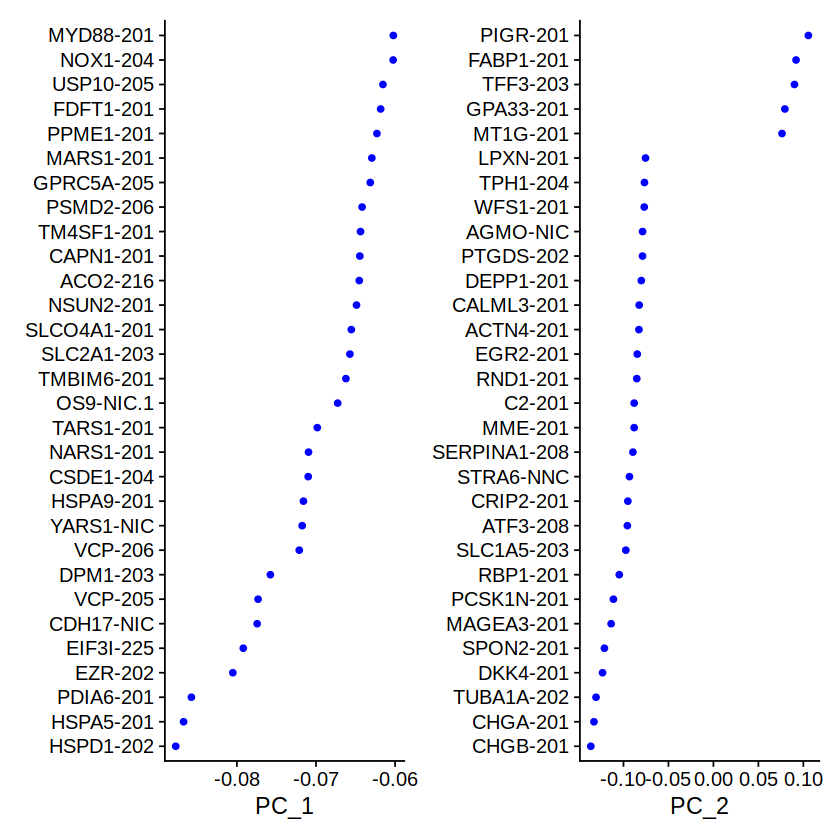

In [14]:
## Perform linear dimensional reduction
ont <- RunPCA(ont, features = ont_hvg, npcs = 50)
# Examine and visualize PCA results a few different ways #print(SG[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(ont, dims = 1:2, reduction = "pca")

Saving 6.67 x 2.8 in image


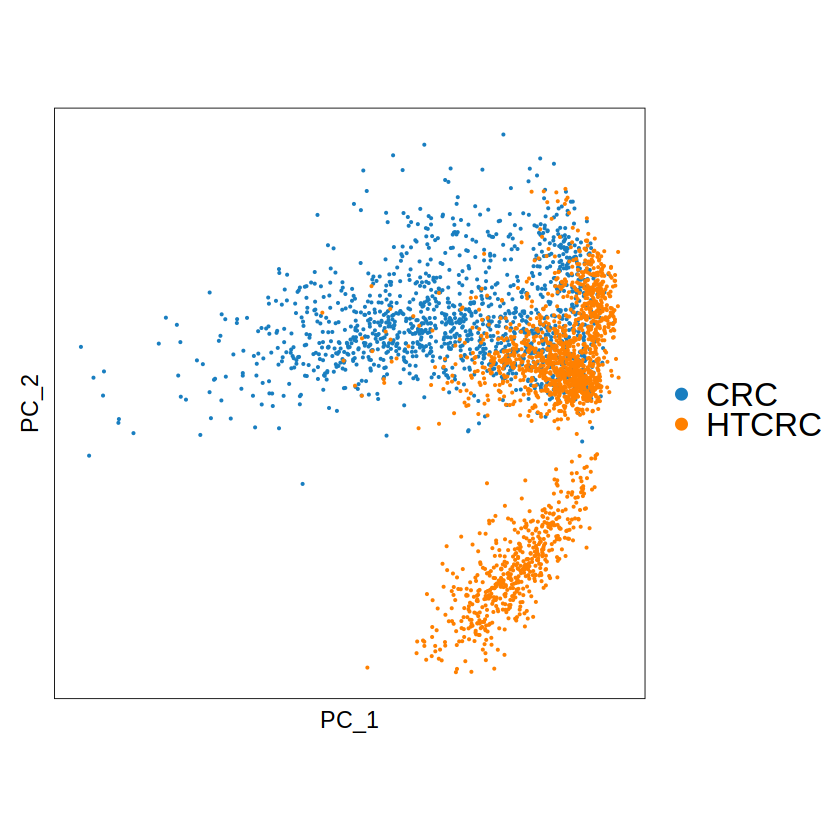

Saving 6.67 x 2.8 in image


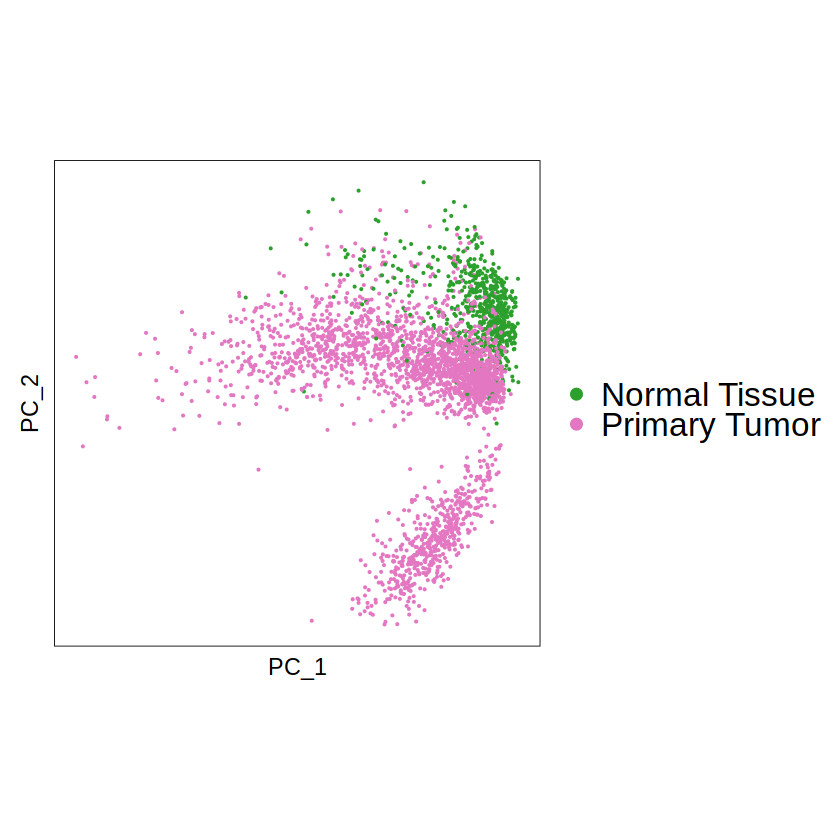

Saving 6.67 x 2.8 in image


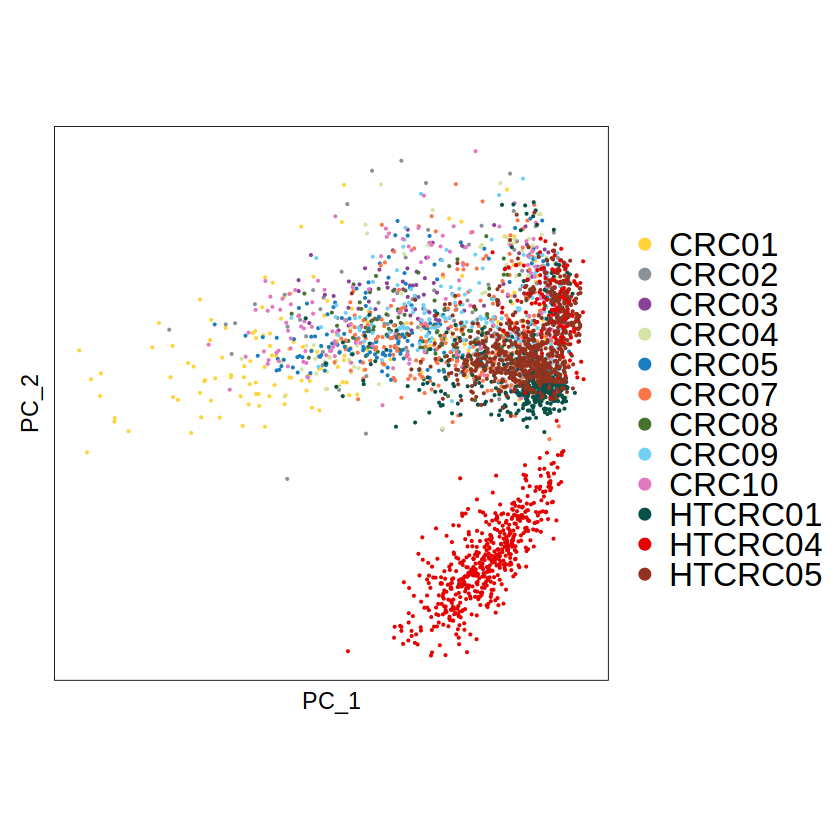

Saving 6.67 x 2.8 in image


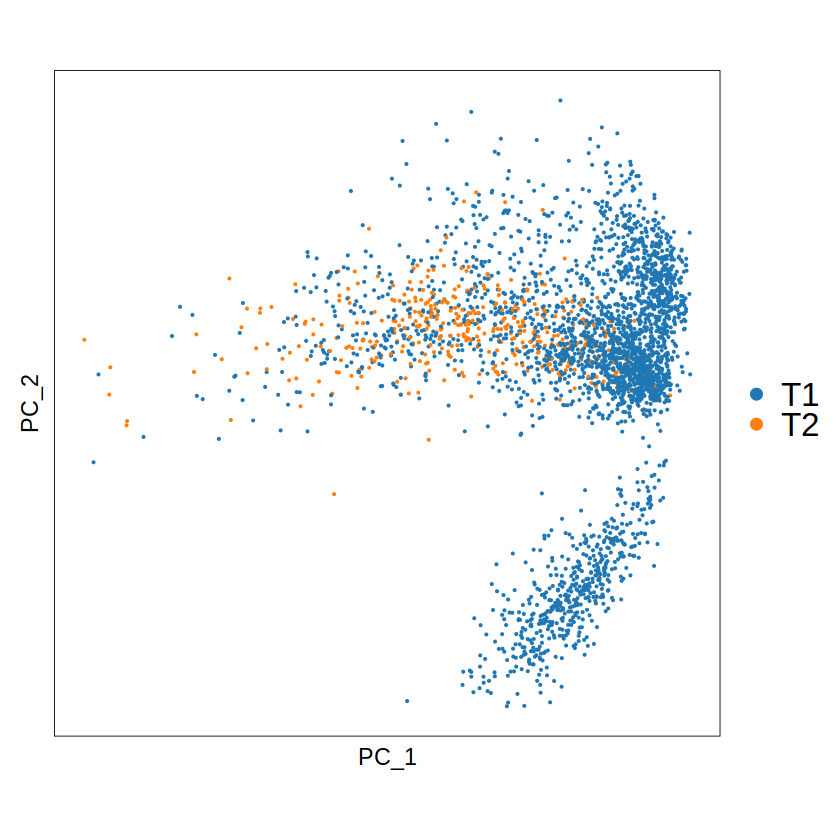

In [15]:
dim_1 <- 1
dim_2 <- 2
DimPlot(ont, reduction = "pca", dims = c(1, 2), group.by = "data") +
  scale_color_manual(values = data_color) + dimplot_theme
ggsave(sprintf("1_ONT_PCA_%d_%d_%s.pdf", dim_1, dim_2, "data"), height = 2.8)

DimPlot(ont, reduction = "pca", dims = c(1, 2), group.by = "Tissue") +
  scale_color_manual(values = tissue_color) + dimplot_theme
ggsave(sprintf("1_ONT_PCA_%d_%d_%s.pdf", dim_1, dim_2, "Tissue"), height = 2.8)

DimPlot(ont, reduction = "pca", dims = c(1, 2), group.by = "patient") +
  scale_color_manual(values = patient_color) + dimplot_theme
ggsave(sprintf("1_ONT_PCA_%d_%d_%s.pdf", dim_1, dim_2, "patient"), height = 2.8)

DimPlot(ont, reduction = "pca", dims = c(1, 2), group.by = "position") +
  scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("1_ONT_PCA_%d_%d_%s.pdf", dim_1, dim_2, "position"), height = 2.8)

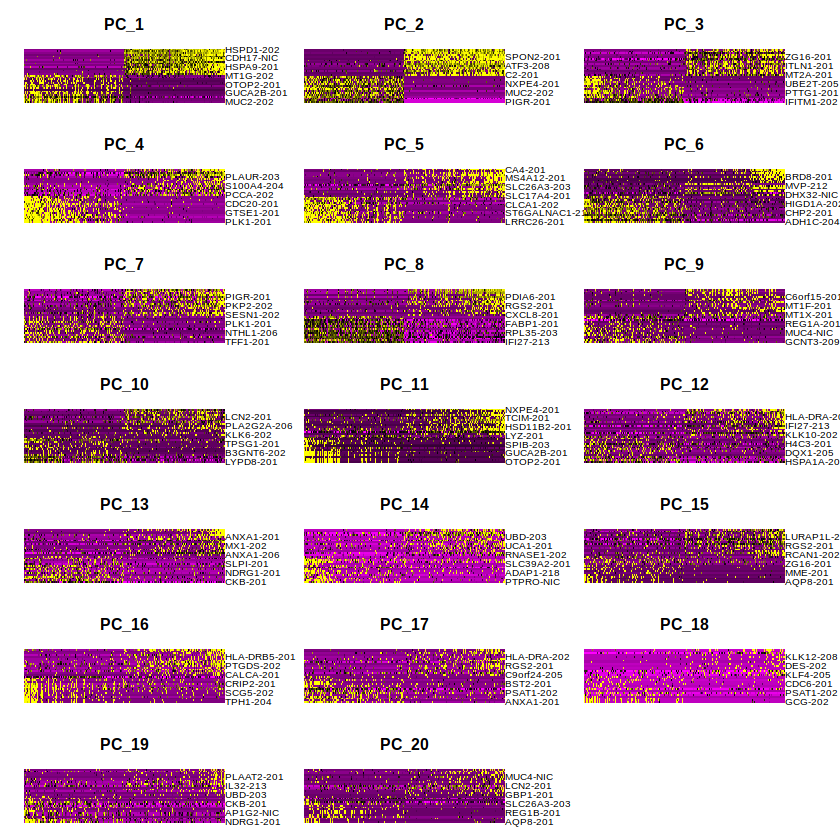

In [16]:
DimHeatmap(ont, dims = 1:20, cells = 500, balanced = TRUE)

In [ ]:
## Determine the ‘dimensionality’ of the dataset
ont <- JackStraw(ont, num.replicate = 200, dims = 50)
ont <- ScoreJackStraw(ont, dims = 1:50)
JackStrawPlot(ont, dims = 1:50)
ElbowPlot(ont, ndims = 50)

## tsne

In [ ]:
# Dimension reduction and cell clustering
dim_FindNeighbors_1 <- 1
dim_FindNeighbors_2 <- 20
ont <- FindNeighbors(ont, dims = c(dim_FindNeighbors_1:dim_FindNeighbors_2))

ont <- RunTSNE(ont, dims = dim_FindNeighbors_1:dim_FindNeighbors_2)
ont <- RunUMAP(ont, dims = dim_FindNeighbors_1:dim_FindNeighbors_2)

Saving 6.67 x 2.8 in image


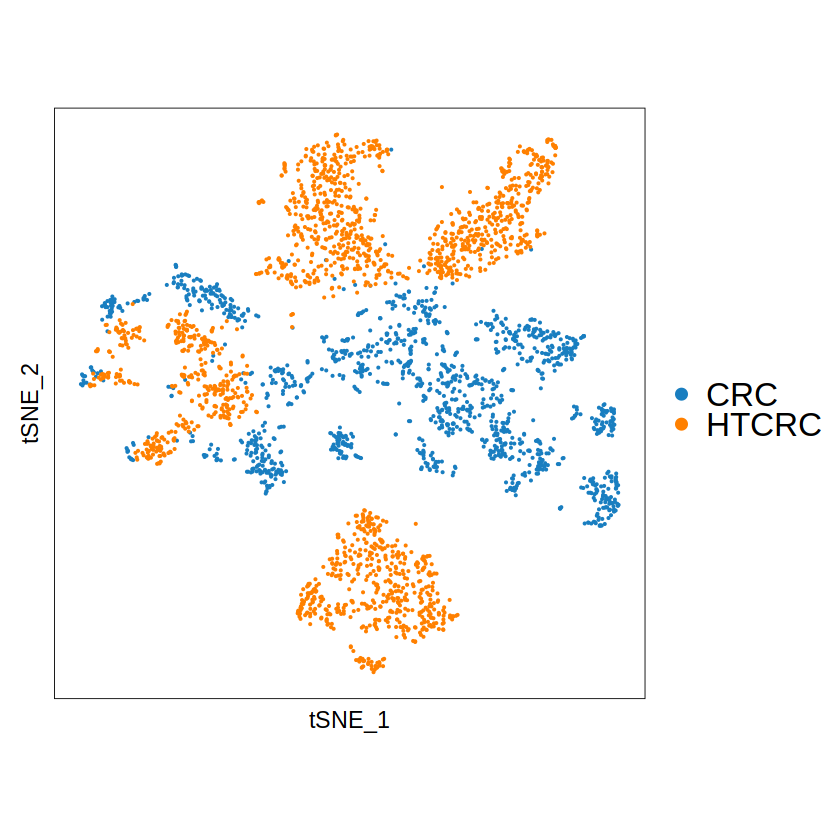

Saving 6.67 x 2.8 in image


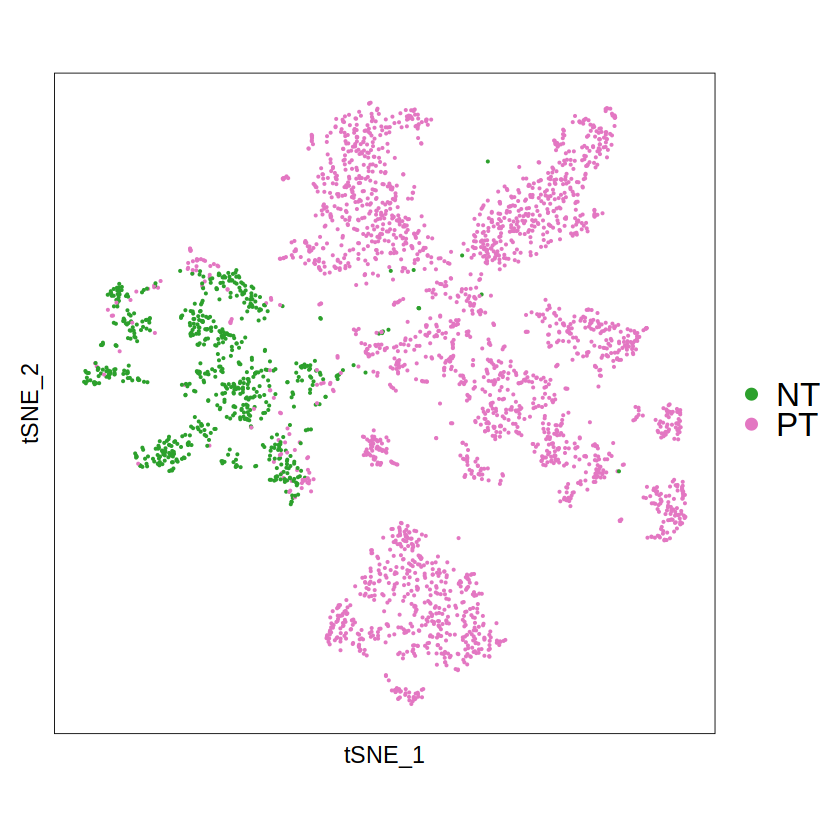

Saving 6.67 x 2.8 in image


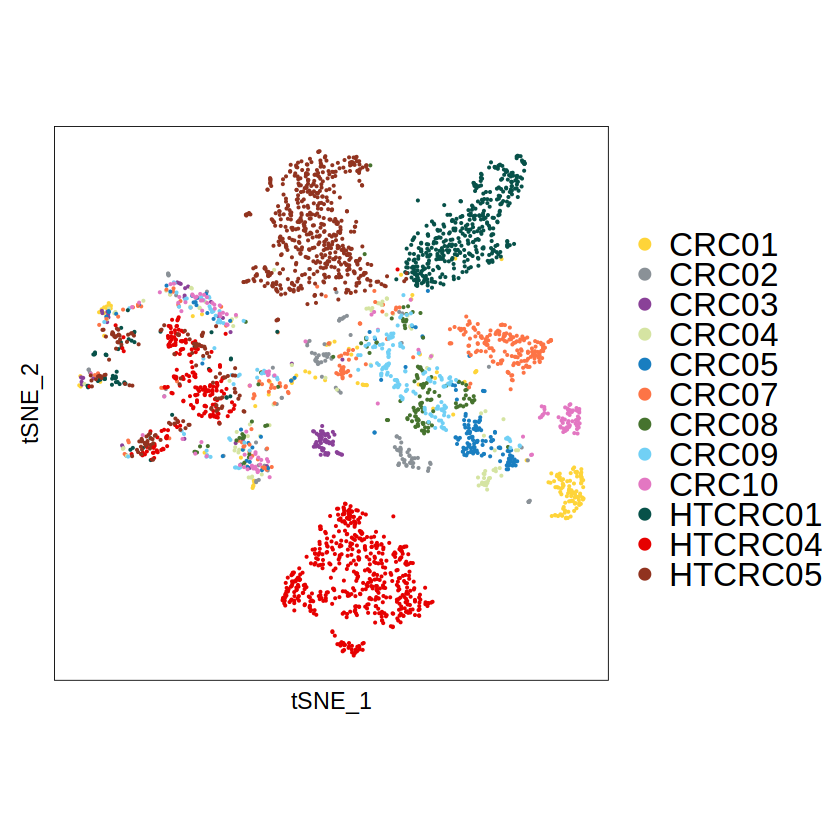

Saving 6.67 x 2.8 in image


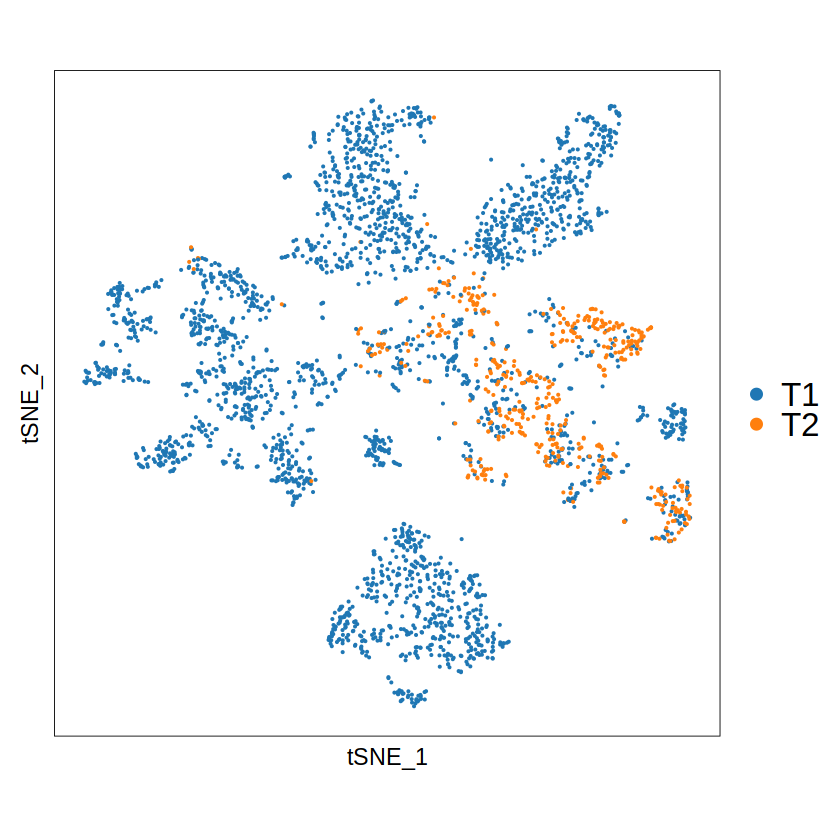

Saving 6.67 x 2.8 in image


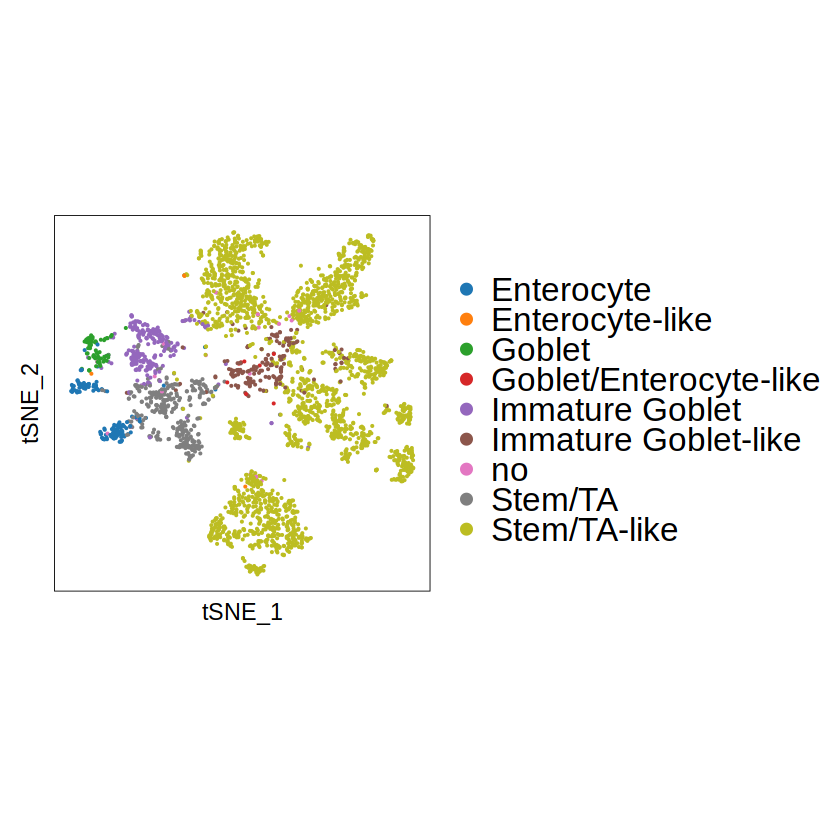

In [18]:
DimPlot(ont, reduction = "tsne", dims = c(1, 2), group.by = "data") +
  scale_color_manual(values = data_color) + dimplot_theme
ggsave(sprintf("1_ONT_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "data"), height = 2.8)

DimPlot(ont, reduction = "tsne", dims = c(1, 2), group.by = "tissue") +
  scale_color_manual(values = tissue_color) + dimplot_theme
ggsave(sprintf("1_ONT_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "tissue"), height = 2.8)

DimPlot(ont, reduction = "tsne", dims = c(1, 2), group.by = "patient") +
  scale_color_manual(values = patient_color) + dimplot_theme
ggsave(sprintf("1_ONT_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "patient"), height = 2.8)

DimPlot(ont, reduction = "tsne", dims = c(1, 2), group.by = "position") +
  scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("1_ONT_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "position"), height = 2.8)

DimPlot(ont, reduction = "tsne", dims = c(1, 2), group.by = "celltype_old") +
  scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("1_ONT_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "celltype_old"), height = 2.8)

In [19]:
for (i in c(0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6)) {
  ont <- FindClusters(ont, resolution = i)
}
# plot resolution
for (myres in c(0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3)) {
  DimPlot(ont, reduction = "tsne", dims = c(1, 2), group.by = sprintf("RNA_snn_res.%s", myres), label = T) +
    dimplot_theme + guides(col = guide_legend(ncol = 1))
  ggsave(sprintf("1_ONT_TSNE_%s_%s_res_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, myres), height = 2.8)
}

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3262
Number of edges: 113712

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9620
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3262
Number of edges: 113712

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9418
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3262
Number of edges: 113712

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9268
Number of communities: 9
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3262
Number of edges: 113712

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9136
Number of communities: 11
Elapsed time: 0 seconds
Modularity Optimize

Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image


In [20]:
pca_coor <- as.data.frame(ont@reductions$pca@cell.embeddings)
ont[["PC_1"]] <- pca_coor$PC_1
ont[["PC_2"]] <- pca_coor$PC_2
tsne_coor <- as.data.frame(ont@reductions$tsne@cell.embeddings)
ont[["tSNE_1"]] <- tsne_coor$tSNE_1
ont[["tSNE_2"]] <- tsne_coor$tSNE_2

# Seurat - gene

In [ ]:
# New assay
ont[["GENE"]] <- CreateAssayObject(counts = gene_cts, min.cells = 0, min.features = 0)
ont <- NormalizeData(ont, assay = "GENE", normalization.method = "LogNormalize", scale.factor = 100000)
ont <- ScaleData(ont, assay = "GENE", features = rownames(ont[["GENE"]])) # ,vars.to.regress = c("nUMI")

## featureplot-gene

In [23]:
DefaultAssay(ont) <- "GENE"

In [ ]:
marker <- read.table(file = "../../marker/crc_marker_v3.txt", header = T, sep = "\t")

In [25]:
for (event in names(table(marker$event1))) {
  mymarker <- marker[which(marker$event1 %in% event), ]$GeneName
  gene <- intersect(mymarker, rownames(GetAssayData(object = ont, slot = "counts")))
  gene <- sort(gene)
  print(c(event, gene))
  for (g in gene) {
    FeaturePlot(ont, features = g, reduction = "tsne", ncol = 1) + featureplot_theme
    ggsave(sprintf("featureplot_gene/3_featureplot_tsne_%s_%s.pdf", event, g), height = 3.5, width = 4, limitsize = FALSE)
  }
}

[1] "B cells" "DERL3"  
[1] "blood" "HBA1"  "HBA2" 
[1] "Bottom crypt" "ASCL2"        "OLFM4"       
[1] "DC"   "CST3" "LYZ" 
[1] "endothelial" "ENG"        
 [1] "enterocyte" "ANPEP"      "AQP8"       "CA1"        "CA2"       
 [6] "CDH1"       "CDX2"       "CLCA4"      "FABP1"      "FABP2"     
[11] "GUCA2B"     "KRT20"      "SLC26A2"    "SLC26A3"    "TMEM37"    
[1] "enteroendocrine" "CHGA"            "CHGB"            "NEUROD1"        
[5] "PROX1"           "PYY"             "REG4"           
[1] "epithelial" "CDH1"       "CLDN4"      "CLDN7"      "EPCAM"     
[6] "KRT19"      "KRT20"     
[1] "fibroblast"
 [1] "G1_S"     "ATAD2"    "BLM"      "BRIP1"    "CASP8AP2" "CCNE2"   
 [7] "CDC45"    "CDC6"     "CDCA7"    "CENPU"    "CHAF1B"   "DSCC1"   
[13] "DTL"      "E2F8"     "EXO1"     "FEN1"     "GINS2"    "GMNN"    
[19] "HELLS"    "MCM2"     "MCM4"     "MCM6"     "MSH2"     "NASP"    
[25] "PCNA"     "POLA1"    "POLD3"    "PRIM1"    "RAD51"    "RAD51AP1"
[31] "RPA2"     "RRM1"     

## featureplot-tx

In [26]:
DefaultAssay(ont) <- "RNA"

In [27]:
tx_info <- read.table(file = "../../CRC_HTCRC_00_gene_isoform_info/00_corrected_ref_TranID_TranName_GeneName_structural_category.txt", header = T, sep = "\t")
head(tx_info, 1)

TranID          TranName  GeneName GeneID          structural_category
1 ENST00000562695 MOSMO-204 MOSMO    ENSG00000185716 FSM                
  subcategory    
1 reference_match

In [28]:
marker <- read.table(file = "../../marker/crc_marker_v3.txt", header = T, sep = "\t")
marker <- merge(marker[, c("GeneName", "event1")], tx_info[, c("GeneName", "TranName")], by = "GeneName", all.x = T)
marker <- marker[!duplicated(marker), ]
marker <- marker[!is.na(marker$TranName), ]
dim(marker)

[1] 322   3

In [29]:
for (event in names(table(marker$event1))) {
  mymarker <- marker[which(marker$event1 %in% event), ]$TranName
  tx <- intersect(mymarker, rownames(GetAssayData(object = ont, slot = "counts")))
  tx <- sort(tx)
  print(c(event, tx))
  for (t in tx) {
    FeaturePlot(ont, features = t, reduction = "tsne", ncol = 1) + featureplot_theme
    ggsave(sprintf("featureplot_tx/3_featureplot_tsne_%s_%s.pdf", event, t), height = 3.5, width = 4, limitsize = FALSE)
  }
}

[1] "B cells"   "DERL3-202" "DERL3-204" "DERL3-208"
[1] "blood"    "HBA1-201" "HBA1-203" "HBA2-201"
[1] "Bottom crypt" "ASCL2-201"    "OLFM4-201"   
[1] "DC"       "CST3-201" "CST3-203" "LYZ-201"  "LYZ-203" 
[1] "endothelial" "ENG-202"    
 [1] "enterocyte"  "ANPEP-201"   "ANPEP-210"   "AQP8-201"    "CA1-204"    
 [6] "CA1-223"     "CA1-NIC"     "CA2-201"     "CA2-202"     "CA2-204"    
[11] "CDH1-204"    "CDH1-NIC"    "CDX2-201"    "CDX2-202"    "CLCA4-201"  
[16] "FABP1-201"   "FABP1-NIC"   "FABP2-201"   "GUCA2B-201"  "KRT20-NIC"  
[21] "SLC26A2-201" "SLC26A3-203" "TMEM37-201" 
 [1] "enteroendocrine" "CHGA-201"        "CHGB-201"        "NEUROD1-201"    
 [5] "PROX1-203"       "PROX1-204"       "PROX1-205"       "PYY-203"        
 [9] "REG4-201"        "REG4-203"       
 [1] "epithelial" "CDH1-204"   "CDH1-NIC"   "CLDN4-201"  "CLDN4-203" 
 [6] "CLDN7-201"  "CLDN7-202"  "CLDN7-207"  "EPCAM-201"  "EPCAM-203" 
[11] "KRT19-201"  "KRT19-204"  "KRT19-205"  "KRT19-207"  "KRT20-NIC" 
 [1] "G1

In [32]:
clas <- read.table(file = "../../CRC_HTCRC_00_gene_isoform_info/00_corrected_ref_TranID_TranName_GeneName_structural_category.txt", header = T, sep = "\t")

DefaultAssay(ont) <- "RNA"
mygene <- "EPCAM"
myiso <- clas[which(clas$GeneName %in% mygene), ]$TranName
for (i in myiso) {
  FeaturePlot(ont, features = i, reduction = "tsne", ncol = 1) + featureplot_theme
  ggsave(sprintf("featureplot_tx_%s.pdf", i), height = 3.5, width = 4, limitsize = FALSE)
}

# Select res and define celltype1

In [358]:
table(ont@meta.data$`RNA_snn_res.0.1`, ont@meta.data$Tissue)

   
    Normal Tissue Primary Tumor
  0            10           923
  1           674           124
  2             1           524
  3             4           504
  4             3           436
  5             0            59

In [34]:
ont@meta.data$celltype1 <- "Cancer cells"
ont@meta.data[which(ont@meta.data$`RNA_snn_res.0.1` %in% c(1)), ]$celltype1 <- "Normal epithelium"
ont@meta.data$celltype1 <- factor(as.character(ont@meta.data$celltype1), levels = c("Normal epithelium", "Cancer cells"))
table(ont@meta.data$celltype1)


Normal epithelium      Cancer cells 
              798              2464 

Saving 6.67 x 2.8 in image


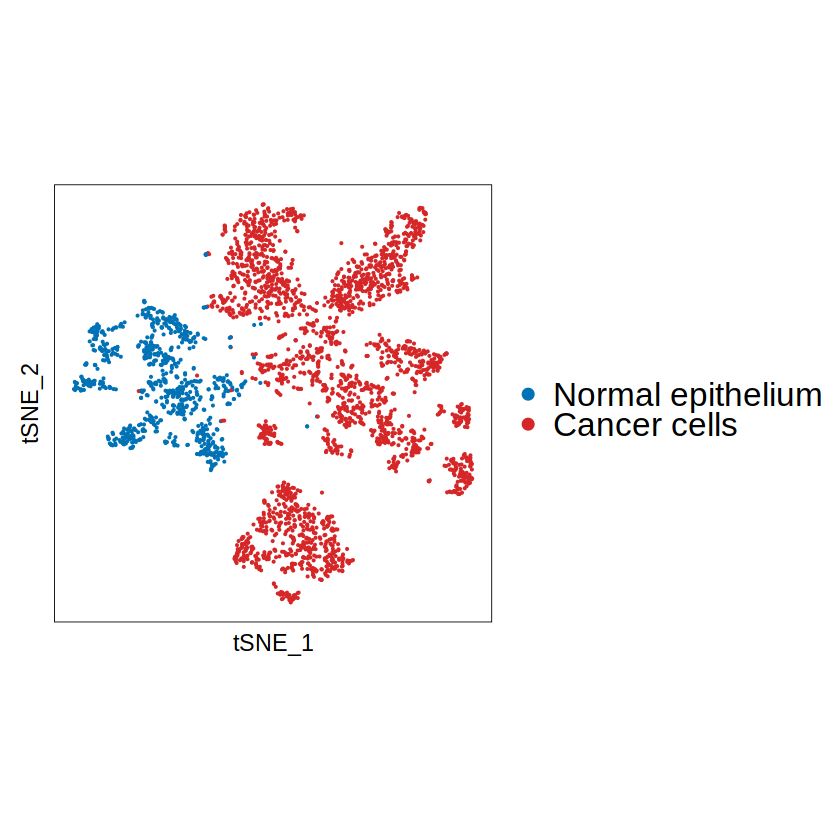

In [35]:
DimPlot(ont, reduction = "tsne", dims = c(1, 2), group.by = "celltype1") +
  scale_color_manual(values = celltype1_color) + dimplot_theme
ggsave(sprintf("1_ONT_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "celltype1"), height = 2.8)

In [36]:
# for inferCNV
ont@meta.data$celltype1_1 <- ont@meta.data$patient
ont@meta.data[which(ont@meta.data$celltype1 %in% "Normal epithelium"), ]$celltype1_1 <- "NE"
ont@meta.data[which(ont@meta.data$celltype1 %in% "Cancer cells"), ]$celltype1_1 <- sprintf("CC_%s", ont@meta.data[which(ont@meta.data$celltype1 %in% "Cancer cells"), ]$patient)
table(ont@meta.data$celltype1_1)
ont@meta.data$celltype1_2 <- "NE"
ont@meta.data[which(ont@meta.data$celltype1 %in% "Cancer cells"), ]$celltype1_2 <- "CC_AllPatients"
table(ont@meta.data$celltype1_2)


  CC_CRC01   CC_CRC02   CC_CRC03   CC_CRC04   CC_CRC05   CC_CRC07   CC_CRC08 
       131         89         61         62        130        216        111 
  CC_CRC09   CC_CRC10 CC_HTCRC01 CC_HTCRC04 CC_HTCRC05         NE 
       145         76        413        526        504        798 


CC_AllPatients             NE 
          2464            798 

# NE subtype (celltype2)

In [360]:
ont_ne <- subset(ont, cells = ont@meta.data[which(ont@meta.data$celltype1 %in% "Normal epithelium"), ]$CellName)
DefaultAssay(ont_ne) <- "GENE"
ont_ne <- NormalizeData(ont_ne, normalization.method = "LogNormalize", scale.factor = 100000)
ont_ne <- ScaleData(ont_ne, features = rownames(ont_ne)) # ,vars.to.regress = c("nUMI")

DefaultAssay(ont_ne) <- "RNA"
ont_ne <- NormalizeData(ont_ne, normalization.method = "LogNormalize", scale.factor = 100000)
ont_ne <- ScaleData(ont_ne, features = rownames(ont_ne)) # ,vars.to.regress = c("nUMI")
ont_ne <- RunPCA(ont_ne, features = VariableFeatures(object = ont_ne), npcs = 50)

Centering and scaling data matrix

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 17 features requested have zero variance (running reduction without them): KLK8-212, PLAT-201, GGT1-NIC.2, SNX20-202, FOXM1-NIC, SERPING1-201, RN7SL751P-201, LETM2-207, AURKA-205, EEF1A1-216, PTGES2-216, DYNLT3-202, S100A3-202, HSPB6-201, RPS18-NIC.1, ETV7-204, NFE2-202”
PC_ 1 
Positive:  PDIA6-201, HSPA5-201, HSPD1-202, EIF3I-225, EZR-202, CDH17-NIC, NOX1-204, NARS1-201, TMBIM6-201, DPM1-203 
	   PKP2-202, SIAE-201, PCCA-202, PGM1-202, GOLM1-202, OLFM4-201, CES2-201, STAT3-202, HSPA9-201, SDHA-201 
	   OS9-NIC.1, FDFT1-201, DSP-NNC, CAPN1-201, NXPE4-201, APEH-201, ADH1C-204, MRPL21-201, ALDH1A1-201, LGALS3BP-201 
Negative:  ZG16-201, TFF3-203, MUC2-202, GUCA2B-201, CA7-201, ITLN1-201, LYPD8-201, OTOP2-201, CLCA1-202, PYY-203 
	   PCSK1N-201, INSL5-201, HLA-B-257, CA4-201, FABP1-201, CHGA-201, TPI1-209, SERPINA1-208, 7S

## select hvg

In [361]:
# select top 1000 highly variable genes from data CRC and HTCRC, respectively
ont_ne_crc <- subset(ont_ne, cells = ont_ne@meta.data[which(ont_ne@meta.data$data %in% "CRC"), ]$CellName)
ont_ne_crc <- NormalizeData(ont_ne_crc, normalization.method = "LogNormalize", scale.factor = 100000)
ont_ne_crc <- FindVariableFeatures(ont_ne_crc, selection.method = "vst", nfeatures = 1000)

ont_ne_htcrc <- subset(ont_ne, cells = ont_ne@meta.data[which(ont_ne@meta.data$data %in% "HTCRC"), ]$CellName)
ont_ne_htcrc <- NormalizeData(ont_ne_htcrc, normalization.method = "LogNormalize", scale.factor = 100000)
ont_ne_htcrc <- FindVariableFeatures(ont_ne_htcrc, selection.method = "vst", nfeatures = 1000)

ont_ne_hvg <- unique(c(VariableFeatures(ont_ne_crc), VariableFeatures(ont_ne_htcrc)))
ont_ne@assays$RNA@var.features <- ont_ne_hvg
length(VariableFeatures(ont_ne))

[1] 1912

PC_ 1 
Positive:  ZG16-201, TFF3-203, MUC2-202, GUCA2B-201, LYPD8-201, ITLN1-201, CA7-201, CLCA1-202, OTOP2-201, HLA-B-257 
	   PYY-203, CA4-201, PCSK1N-201, 7SK.1-201, SERPINA1-208, INSL5-201, FABP1-201, GSN-209, CHGA-201, CEACAM7-201 
	   AQP8-201, GCG-202, SLC17A4-201, SMIM5-201, B3GNT6-202, TFF1-201, KRT8-216, PLAAT2-201, MSLN-207, PSCA-201 
Negative:  CD24-204, HSPA5-201, PABPC1-201, RTN3-208, ATP5F1A-220, HSPA8-222, RBMX-201, UGDH-201, NOX1-204, HSPA8-214 
	   ACTR3-208, HNRNPA1-234, TMBIM6-201, NARS1-201, DAP-201, RPN2-201, P4HB-201, GNAS-201, PKP2-202, CAT-201 
	   ALDH3A2-201, HSP90AB1-203, CCNG1-202, KARS1-201, PDIA4-204, SIAE-201, GMDS-202, MRPS22-214, HSPA9-201, GOT2-NIC 
PC_ 2 
Positive:  WFDC2-204, RARRES2-201, STMN1-206, PYY-203, AGR2-203, GCG-202, LDHB-201, EEF1D-202, INSL5-201, RPL8-207 
	   SNHG29-221, RARRES2-203, UCP2-211, ITLN1-201, MRPL37-202, TK1-201, TRAPPC6A-202, PLA2G2A-201, PCBP2-201, CCNG1-201 
	   ATP5F1A-220, CHGA-201, CENPM-201, TFF3-203, NPM3-201, RANBP1

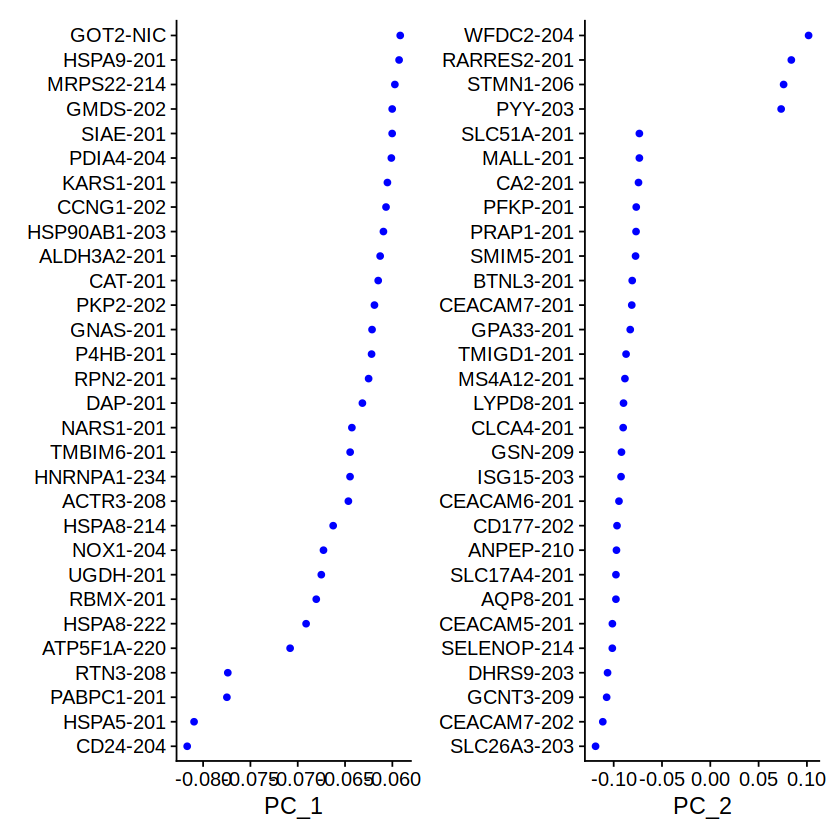

In [362]:
## Perform linear dimensional reduction
ont_ne <- RunPCA(ont_ne, features = ont_ne_hvg, npcs = 50)
# Examine and visualize PCA results a few different ways #print(SG[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(ont_ne, dims = 1:2, reduction = "pca")

Saving 6.67 x 2.8 in image


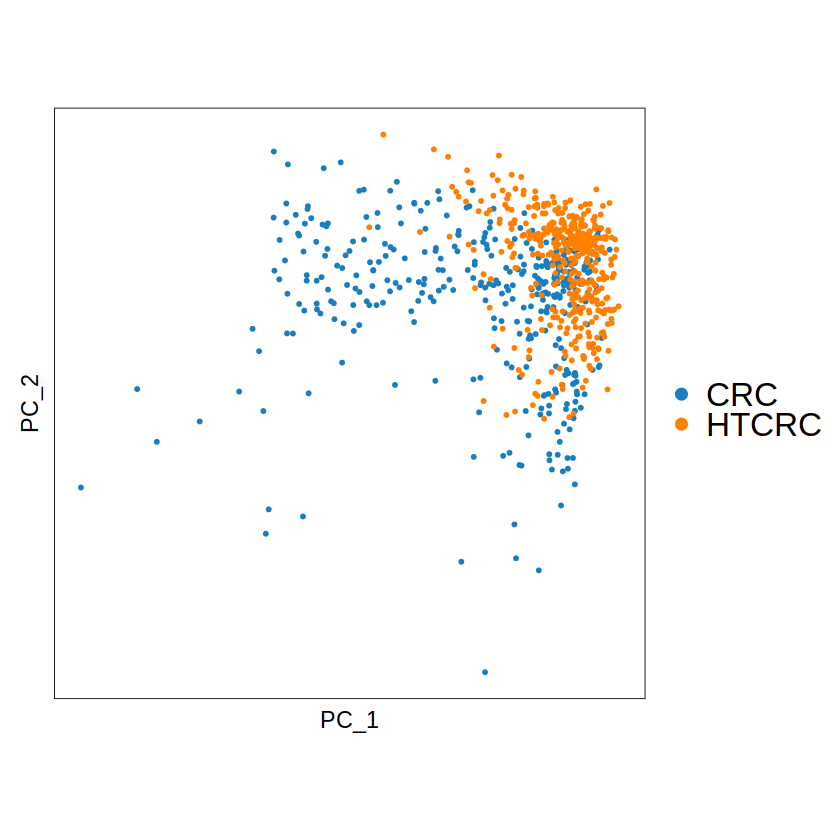

Saving 6.67 x 2.8 in image


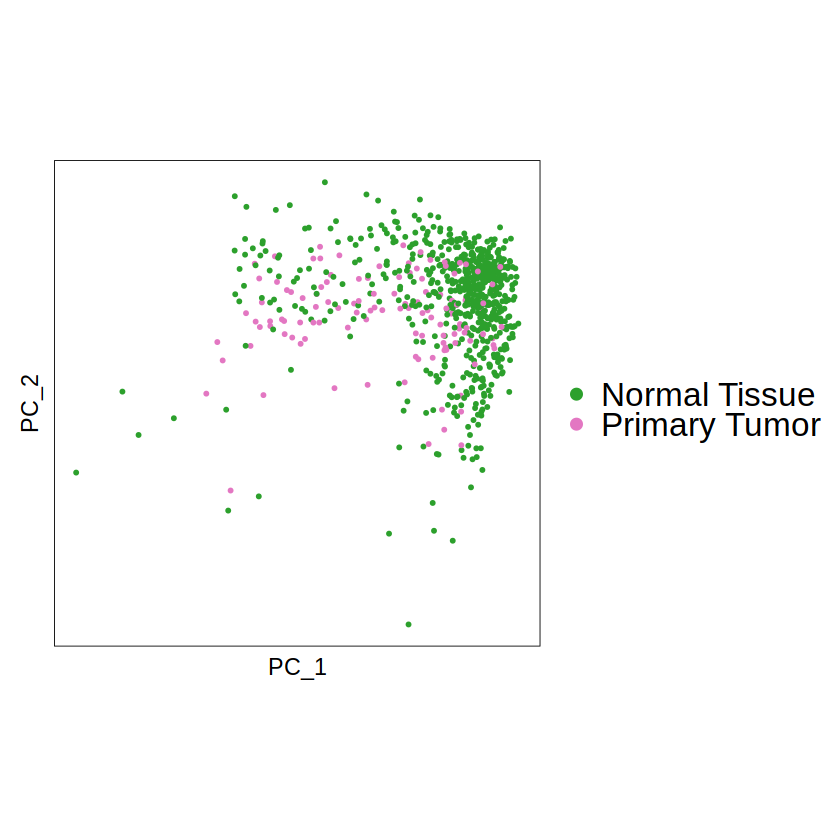

Saving 6.67 x 2.8 in image


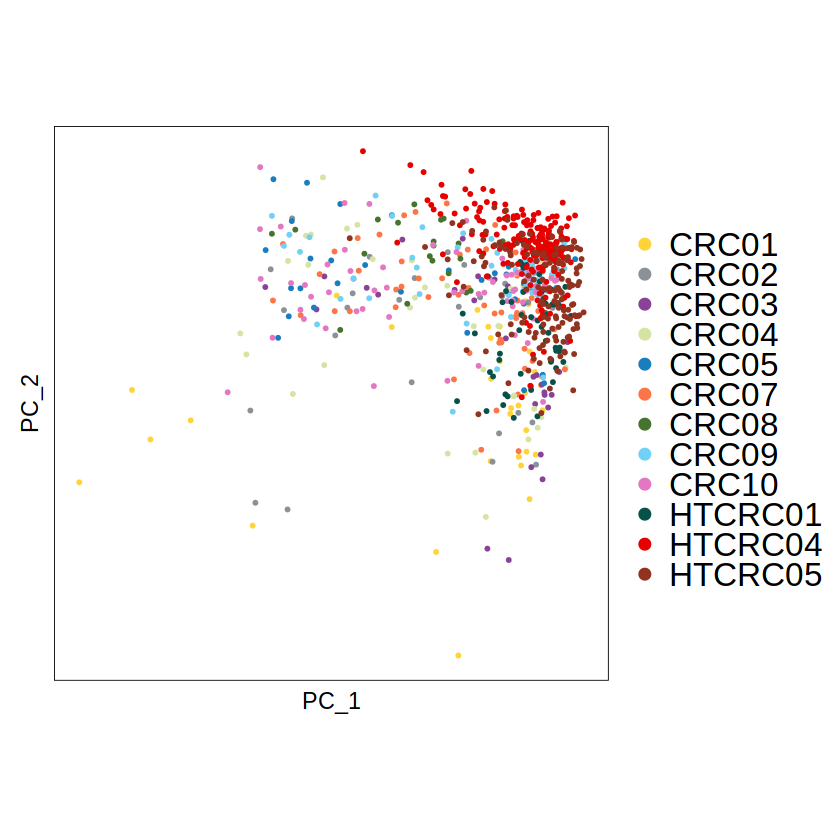

Saving 6.67 x 2.8 in image


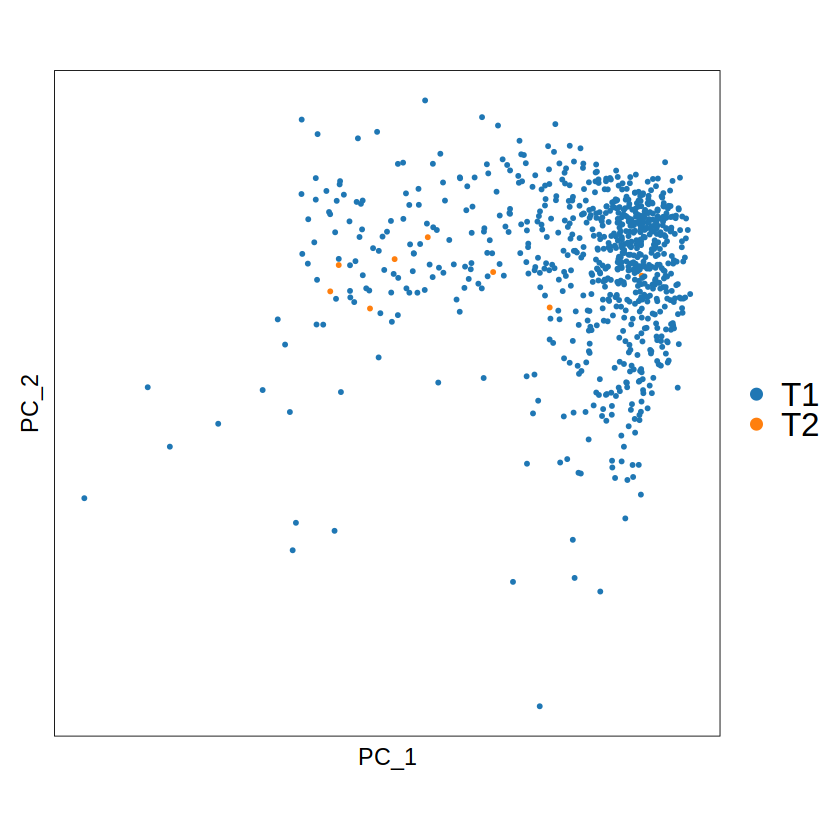

In [363]:
dim_1 <- 1
dim_2 <- 2
DimPlot(ont_ne, reduction = "pca", dims = c(1, 2), group.by = "data") +
  scale_color_manual(values = data_color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_PCA_%d_%d_%s.pdf", dim_1, dim_2, "data"), height = 2.8)

DimPlot(ont_ne, reduction = "pca", dims = c(1, 2), group.by = "Tissue") +
  scale_color_manual(values = tissue_color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_PCA_%d_%d_%s.pdf", dim_1, dim_2, "Tissue"), height = 2.8)

DimPlot(ont_ne, reduction = "pca", dims = c(1, 2), group.by = "patient") +
  scale_color_manual(values = patient_color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_PCA_%d_%d_%s.pdf", dim_1, dim_2, "patient"), height = 2.8)

DimPlot(ont_ne, reduction = "pca", dims = c(1, 2), group.by = "position") +
  scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_PCA_%d_%d_%s.pdf", dim_1, dim_2, "position"), height = 2.8)

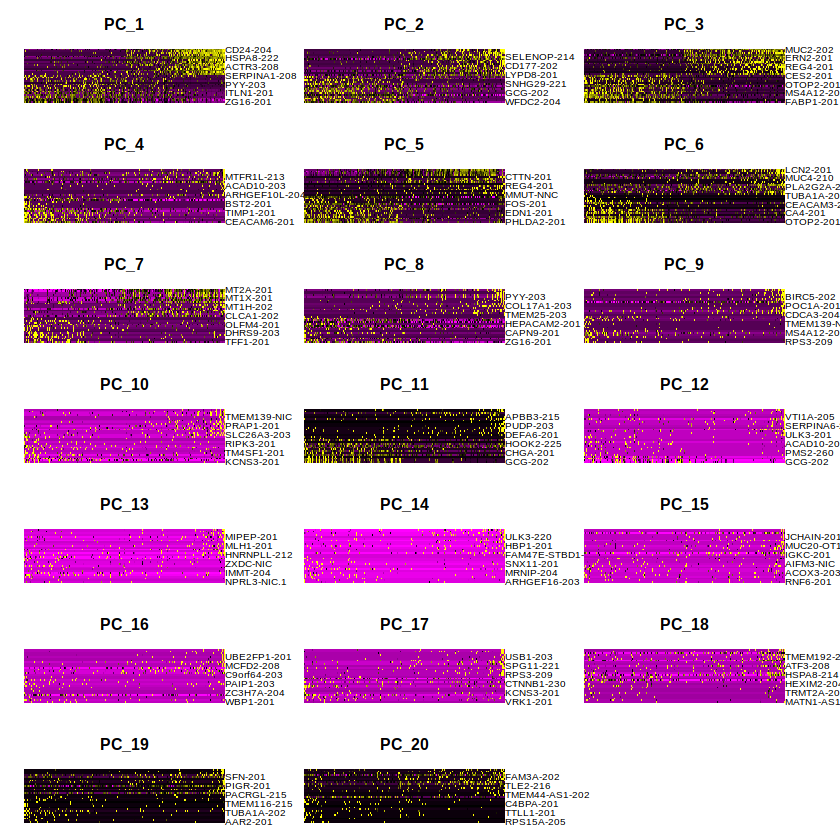

In [364]:
DimHeatmap(ont_ne, dims = 1:20, cells = 500, balanced = TRUE)

In [ ]:
ont_ne <- JackStraw(ont_ne, num.replicate = 200, dims = 50)
ont_ne <- ScoreJackStraw(ont_ne, dims = 1:50)
JackStrawPlot(ont_ne, dims = 1:50)
ElbowPlot(ont_ne, ndims = 50)

## tsne

In [365]:
# Dimension reduction and cell clustering
dim_FindNeighbors_1 <- 1
dim_FindNeighbors_2 <- 30
ont_ne <- FindNeighbors(ont_ne, dims = c(dim_FindNeighbors_1:dim_FindNeighbors_2))

ont_ne <- RunTSNE(ont_ne, dims = dim_FindNeighbors_1:dim_FindNeighbors_2)
ont_ne <- RunUMAP(ont_ne, dims = dim_FindNeighbors_1:dim_FindNeighbors_2)

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:57:09 UMAP embedding parameters a = 0.9922 b = 1.112

15:57:09 Read 798 rows and found 30 numeric columns

15:57:09 Using Annoy for neighbor search, n_neighbors = 30

15:57:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:57:09 Writing NN index file to temp file /tmp/Rtmp2TlcYy/file6f754de9266

15:57:09 Searching Annoy index using 1 thread, search_k = 3000

15:57:09 Annoy recall = 100%

15:57:10 Commencing smooth kNN distance calibr

Saving 6.67 x 2.8 in image


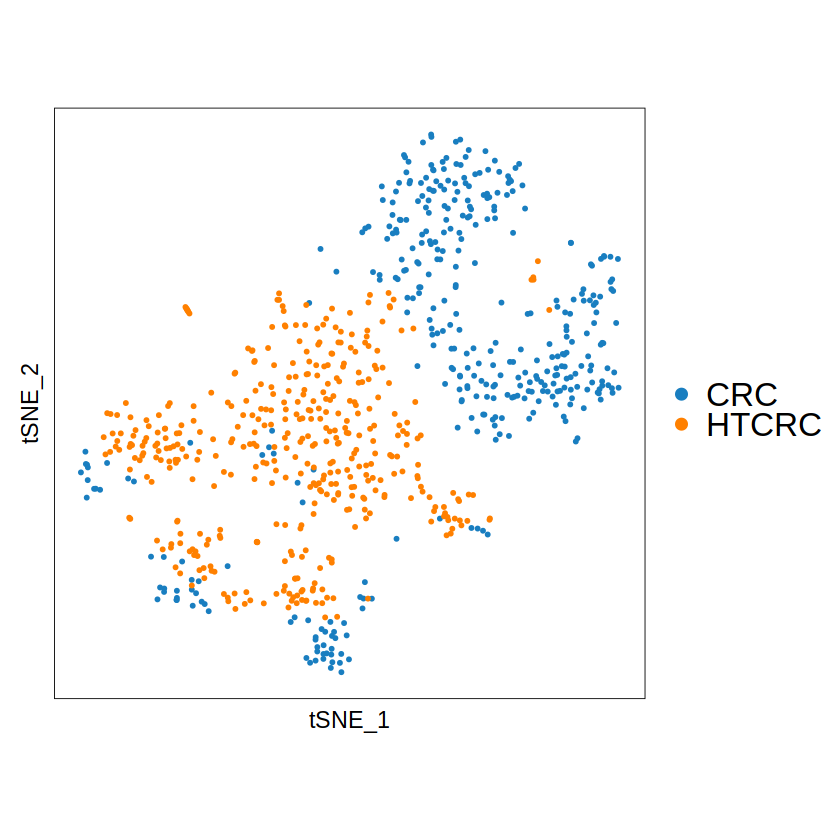

Saving 6.67 x 2.8 in image


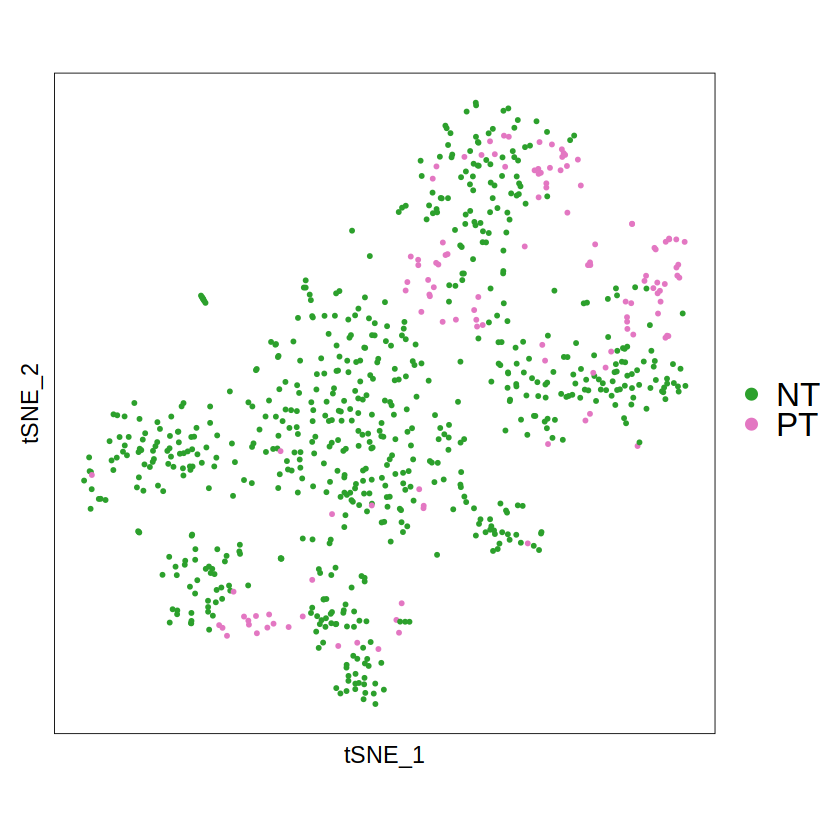

Saving 6.67 x 2.8 in image


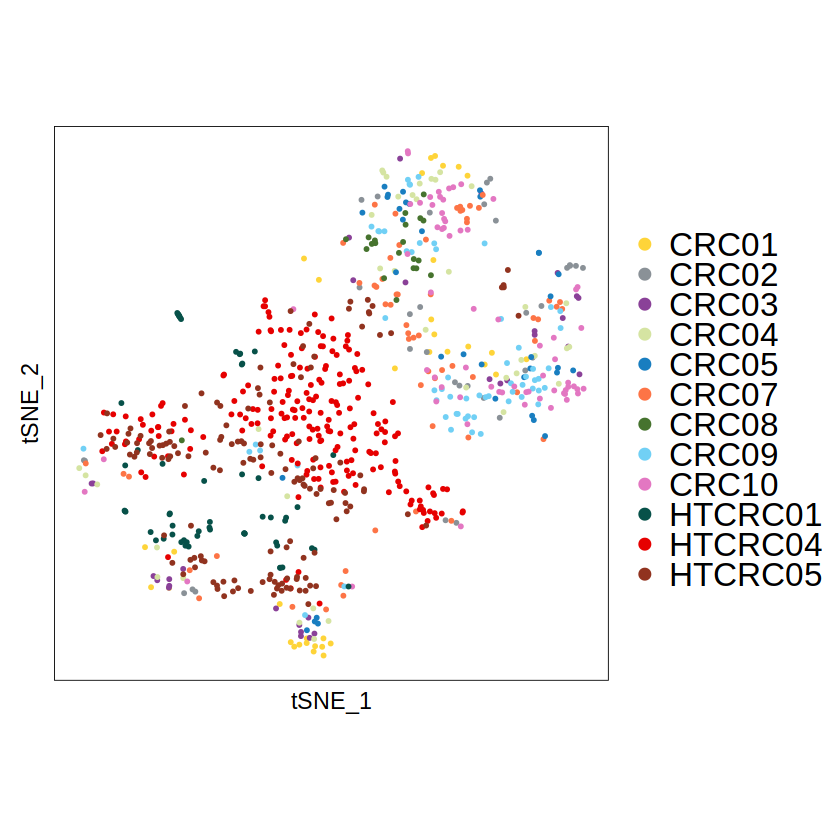

Saving 6.67 x 2.8 in image


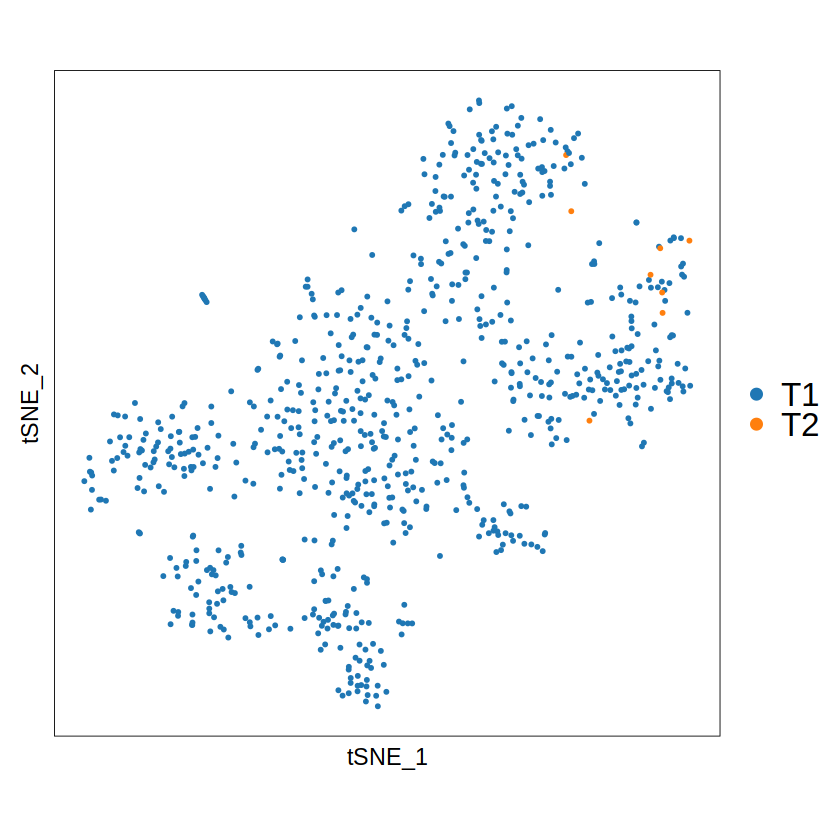

Saving 6.67 x 2.8 in image


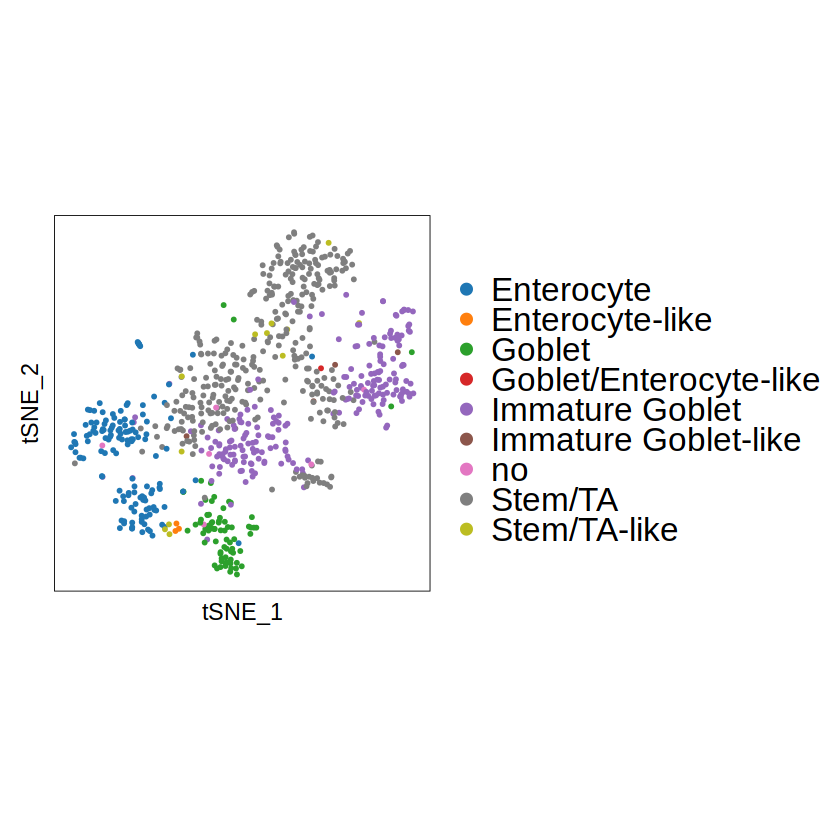

In [366]:
DimPlot(ont_ne, reduction = "tsne", dims = c(1, 2), group.by = "data") +
  scale_color_manual(values = data_color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "data"), height = 2.8)

DimPlot(ont_ne, reduction = "tsne", dims = c(1, 2), group.by = "tissue") +
  scale_color_manual(values = tissue_color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "tissue"), height = 2.8)

DimPlot(ont_ne, reduction = "tsne", dims = c(1, 2), group.by = "patient") +
  scale_color_manual(values = patient_color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "patient"), height = 2.8)

DimPlot(ont_ne, reduction = "tsne", dims = c(1, 2), group.by = "position") +
  scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "position"), height = 2.8)

DimPlot(ont_ne, reduction = "tsne", dims = c(1, 2), group.by = "celltype_old") +
  scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "celltype_old"), height = 2.8)

In [367]:
for (i in c(0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6)) {
  ont_ne <- FindClusters(ont_ne, resolution = i)
}
# plot resolution
for (myres in c(0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3)) {
  DimPlot(ont_ne, reduction = "tsne", dims = c(1, 2), group.by = sprintf("RNA_snn_res.%s", myres), label = T) +
    dimplot_theme + guides(col = guide_legend(ncol = 1))
  ggsave(sprintf("2_ONT_NE_TSNE_%s_%s_res_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, myres), height = 2.8)
}

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 798
Number of edges: 31732

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9126
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 798
Number of edges: 31732

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8664
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 798
Number of edges: 31732

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8427
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 798
Number of edges: 31732

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8190
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version

2 singletons identified. 20 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 798
Number of edges: 31732

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2699
Number of communities: 30
Elapsed time: 0 seconds


3 singletons identified. 27 final clusters.

Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image


## featureplot-gene

In [368]:
DefaultAssay(ont_ne) <- "GENE"

In [ ]:
marker <- read.table(file = "../../marker/crc_marker_v3.txt", header = T, sep = "\t")

In [370]:
for (event in names(table(marker$event1))) {
  mymarker <- marker[which(marker$event1 %in% event), ]$GeneName
  gene <- intersect(mymarker, rownames(GetAssayData(object = ont_ne, slot = "counts")))
  gene <- sort(gene)
  print(c(event, gene))
  for (g in gene) {
    FeaturePlot(ont_ne, features = g, reduction = "tsne", ncol = 1) + featureplot_theme
    ggsave(sprintf("2_ONT_NE_featureplot_gene/3_featureplot_tsne_%s_%s.pdf", event, g), height = 3.5, width = 4, limitsize = FALSE)
  }
}

[1] "B cells" "DERL3"  
[1] "blood" "HBA1"  "HBA2" 
[1] "Bottom crypt" "ASCL2"        "OLFM4"       
[1] "DC"   "CST3" "LYZ" 
[1] "endothelial" "ENG"        
 [1] "enterocyte" "ANPEP"      "AQP8"       "CA1"        "CA2"       
 [6] "CDH1"       "CDX2"       "CLCA4"      "FABP1"      "FABP2"     
[11] "GUCA2B"     "KRT20"      "SLC26A2"    "SLC26A3"    "TMEM37"    
[1] "enteroendocrine" "CHGA"            "CHGB"            "NEUROD1"        
[5] "PROX1"           "PYY"             "REG4"           
[1] "epithelial" "CDH1"       "CLDN4"      "CLDN7"      "EPCAM"     
[6] "KRT19"      "KRT20"     
[1] "fibroblast"
 [1] "G1_S"     "ATAD2"    "BLM"      "BRIP1"    "CASP8AP2" "CCNE2"   
 [7] "CDC45"    "CDC6"     "CDCA7"    "CENPU"    "CHAF1B"   "DSCC1"   
[13] "DTL"      "E2F8"     "EXO1"     "FEN1"     "GINS2"    "GMNN"    
[19] "HELLS"    "MCM2"     "MCM4"     "MCM6"     "MSH2"     "NASP"    
[25] "PCNA"     "POLA1"    "POLD3"    "PRIM1"    "RAD51"    "RAD51AP1"
[31] "RPA2"     "RRM1"     

## featureplot-tx

In [371]:
DefaultAssay(ont_ne) <- "RNA"

In [372]:
tx_info <- read.table(file = "../../CRC_HTCRC_00_gene_isoform_info/00_corrected_ref_TranID_TranName_GeneName_structural_category.txt", header = T, sep = "\t")
head(tx_info, 1)

TranID          TranName  GeneName GeneID          structural_category
1 ENST00000562695 MOSMO-204 MOSMO    ENSG00000185716 FSM                
  subcategory    
1 reference_match

In [373]:
marker <- read.table(file = "../../marker/crc_marker_v3.txt", header = T, sep = "\t")
marker <- merge(marker[, c("GeneName", "event1")], tx_info[, c("GeneName", "TranName")], by = "GeneName", all.x = T)
marker <- marker[!duplicated(marker), ]
marker <- marker[!is.na(marker$TranName), ]
dim(marker)

[1] 324   3

In [374]:
for (event in names(table(marker$event1))) {
  mymarker <- marker[which(marker$event1 %in% event), ]$TranName
  tx <- intersect(mymarker, rownames(GetAssayData(object = ont_ne, slot = "counts")))
  tx <- sort(tx)
  print(c(event, tx))
  for (t in tx) {
    FeaturePlot(ont_ne, features = t, reduction = "tsne", ncol = 1) + featureplot_theme
    ggsave(sprintf("2_ONT_NE_featureplot_tx/3_featureplot_tsne_%s_%s.pdf", event, t), height = 3.5, width = 4, limitsize = FALSE)
  }
}

[1] "B cells"   "DERL3-202" "DERL3-204" "DERL3-208"
[1] "blood"    "HBA1-201" "HBA1-203" "HBA2-201"
[1] "Bottom crypt" "ASCL2-201"    "OLFM4-201"   
[1] "DC"       "CST3-201" "CST3-203" "LYZ-201"  "LYZ-203" 
[1] "endothelial" "ENG-202"    
 [1] "enterocyte"  "ANPEP-201"   "ANPEP-210"   "AQP8-201"    "CA1-204"    
 [6] "CA1-223"     "CA1-NIC"     "CA2-201"     "CA2-202"     "CA2-204"    
[11] "CDH1-204"    "CDH1-NIC"    "CDX2-201"    "CDX2-202"    "CLCA4-201"  
[16] "FABP1-201"   "FABP1-NIC"   "FABP2-201"   "GUCA2B-201"  "KRT20-NIC"  
[21] "SLC26A2-201" "SLC26A3-203" "TMEM37-201" 
 [1] "enteroendocrine" "CHGA-201"        "CHGB-201"        "NEUROD1-201"    
 [5] "PROX1-203"       "PROX1-204"       "PROX1-205"       "PYY-203"        
 [9] "REG4-201"        "REG4-203"       
 [1] "epithelial" "CDH1-204"   "CDH1-NIC"   "CLDN4-201"  "CLDN4-203" 
 [6] "CLDN7-201"  "CLDN7-202"  "CLDN7-207"  "EPCAM-201"  "EPCAM-203" 
[11] "KRT19-201"  "KRT19-204"  "KRT19-205"  "KRT19-207"  "KRT20-NIC" 
 [1] "G1

Warning message in FeaturePlot(ont_ne, features = t, reduction = "tsne", ncol = 1):
“All cells have the same value (0) of POLA1-202.”


  [1] "G2_M"       "ANLN-201"   "ANLN-NIC"   "ANP32E-208" "ANP32E-209"
  [6] "ANP32E-210" "AURKA-202"  "AURKA-203"  "AURKA-205"  "AURKA-206" 
 [11] "AURKA-207"  "AURKA-208"  "AURKA-213"  "AURKB-201"  "AURKB-202" 
 [16] "AURKB-214"  "BIRC5-201"  "BIRC5-202"  "BUB1-201"   "CBX5-201"  
 [21] "CBX5-206"   "CCNB2-201"  "CDC20-201"  "CDC20-202"  "CDC25C-201"
 [26] "CDC25C-NIC" "CDCA2-202"  "CDCA3-201"  "CDCA3-204"  "CDCA3-207" 
 [31] "CDCA8-201"  "CDCA8-202"  "CDK1-203"   "CDK1-204"   "CDK1-NIC"  
 [36] "CENPA-202"  "CENPE-201"  "CENPE-NIC"  "CENPE-NNC"  "CENPF-201" 
 [41] "CKAP2-201"  "CKAP2-202"  "CKAP2-203"  "CKAP2-205"  "CKAP2L-201"
 [46] "CKAP5-210"  "CKS1B-201"  "CKS1B-203"  "CKS2-201"   "CTCF-201"  
 [51] "CTCF-203"   "DLGAP5-201" "DLGAP5-202" "ECT2-201"   "ECT2-204"  
 [56] "ECT2-206"   "ECT2-216"   "ECT2-NIC"   "G2E3-201"   "G2E3-202"  
 [61] "G2E3-207"   "GAS2L3-201" "GAS2L3-205" "GAS2L3-209" "GTSE1-201" 
 [66] "HJURP-202"  "HMGB2-201"  "HMGB2-202"  "HMGB2-203"  "HMGB2-205" 
 [71] 

Warning message in FeaturePlot(ont_ne, features = t, reduction = "tsne", ncol = 1):
“All cells have the same value (0) of ANP32E-209.”
Warning message in FeaturePlot(ont_ne, features = t, reduction = "tsne", ncol = 1):
“All cells have the same value (0) of AURKA-205.”
Warning message in FeaturePlot(ont_ne, features = t, reduction = "tsne", ncol = 1):
“All cells have the same value (0) of AURKB-202.”
Warning message in FeaturePlot(ont_ne, features = t, reduction = "tsne", ncol = 1):
“All cells have the same value (0) of PSRC1-201.”
Warning message in FeaturePlot(ont_ne, features = t, reduction = "tsne", ncol = 1):
“All cells have the same value (0) of PSRC1-203.”


 [1] "goblet"     "CLCA1-202"  "FFAR4-201"  "ITLN1-201"  "MUC2-202"  
 [6] "SPDEF-201"  "SPINK4-201" "TFF3-201"   "TFF3-202"   "TFF3-203"  
[11] "ZG16-201"  
[1] "immune"   "CD14-201" "CD68-201" "CD68-202"
[1] "intestine" "CDX2-201"  "CDX2-202"  "MUC2-202" 
[1] "mast cells" "KIT-213"   
[1] "myeloid"  "CD14-201" "CD68-201" "CD68-202"
 [1] "paneth"      "CA4-201"     "CA4-206"     "CA4-NIC"     "CA4-NIC.1"  
 [6] "CA4-NIC.2"   "CA7-201"     "FKBP1A-201"  "FKBP1A-211"  "FKBP1A-214" 
[11] "FKBP1A-219"  "LYZ-201"     "LYZ-203"     "NUPR1-202"   "PLA2G2A-201"
[16] "PLA2G2A-202" "PLA2G2A-205" "PLA2G2A-206" "SPIB-202"    "SPIB-203"   
[21] "SPIB-205"    "SPIB-208"   
 [1] "progenitor"  "CDK6-201"    "FABP5-201"   "FABP5-204"   "LCN2-201"   
 [6] "LCN2-204"    "LCN2-205"    "LCN2-207"    "MUC4-210"    "MUC4-213"   
[11] "MUC4-NIC"    "PLA2G2A-201" "PLA2G2A-202" "PLA2G2A-205" "PLA2G2A-206"
[16] "SOX9-201"   
 [1] "stem"       "ALCAM-201"  "ALCAM-204"  "ASCL2-201"  "CD24-202"  
 [6] "CD24-204"  

Warning message in FeaturePlot(ont_ne, features = t, reduction = "tsne", ncol = 1):
“All cells have the same value (0) of PROM1-210.”


[1] "Transient-amplifying" "CCNA2-201"            "PCNA-201"            
[4] "PCNA-202"             "TOP2A-NIC"           
[1] "tuft"       "POU2F3-203" "PTGS1-202" 


## Define normal cells using RCA

In [375]:
c295_meta <- readRDS(file = "../../10_other_research/04_Human_colon_cancer_stlas_c295/c295_sample30000_CRC_HTCRC/00_down_sp_1_meta.rds")
c295_cts <- readRDS(file = "../../10_other_research/04_Human_colon_cancer_stlas_c295/c295_OntCrc_sample30000/00_down_sp_1_cts.rds")
c295_cts <- as.data.frame(c295_cts)
all(colnames(c295_cts) == c295_meta$NAME)

c295 <- CreateSeuratObject(counts = c295_cts, meta.data = c295_meta, project = "", min.cells = 0, min.features = 0)
c295
c295 <- NormalizeData(c295, normalization.method = "LogNormalize", scale.factor = 100000)
c295 <- ScaleData(c295, features = rownames(c295))

[1] TRUE

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
10675 features across 33659 samples within 1 assay 
Active assay: RNA (10675 features, 0 variable features)

Centering and scaling data matrix



In [376]:
c295 <- CreateSeuratObject(counts = c295_cts, meta.data = c295_meta, project = "", min.cells = 0, min.features = 0)
c295
c295 <- NormalizeData(c295, normalization.method = "LogNormalize", scale.factor = 100000)
c295 <- ScaleData(c295, features = rownames(c295))

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
10675 features across 33659 samples within 1 assay 
Active assay: RNA (10675 features, 0 variable features)

Centering and scaling data matrix



In [377]:
names(table(c295@meta.data$celltype3))

[1] "cE01 (Stem/TA-like)"                      
 [2] "cE02 (Stem/TA-like/Immature Goblet)"      
 [3] "cE03 (Stem/TA-like prolif)"               
 [4] "cE04 (Enterocyte 1)"                      
 [5] "cE05 (Enterocyte 2)"                      
 [6] "cE06 (Immature Goblet)"                   
 [7] "cE07 (Goblet/Enterocyte)"                 
 [8] "cE08 (Goblet)"                            
 [9] "cE09 (Best4)"                             
[10] "cE10 (Tuft)"                              
[11] "cE11 (Enteroendocrine)"                   
[12] "Tumor cE01 (Stem/TA-like)"                
[13] "Tumor cE02 (Stem/TA-like/Immature Goblet)"
[14] "Tumor cE03 (Stem/TA-like prolif)"         
[15] "Tumor cE04 (Enterocyte 1)"                
[16] "Tumor cE05 (Enterocyte 2)"                
[17] "Tumor cE06 (Immature Goblet)"             
[18] "Tumor cE07 (Goblet/Enterocyte)"           
[19] "Tumor cE08 (Goblet)"                      
[20] "Tumor cE09 (Best4)"                       
[21] "Tumor cE10 (Tuft)"                        
[22] "Tumor cE11 (Enteroendocrine)"

In [378]:
ne_panel <- data.frame(
  `cE01 (Stem/TA-like)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE01 (Stem/TA-like)"), ]$CellName
  )]),
  `cE02 (Stem/TA-like/Immature Goblet)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE02 (Stem/TA-like/Immature Goblet)"), ]$CellName
  )]),
  `cE03 (Stem/TA-like prolif)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE03 (Stem/TA-like prolif)"), ]$CellName
  )]),
  `cE04 (Enterocyte 1)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE04 (Enterocyte 1)"), ]$CellName
  )]),
  `cE05 (Enterocyte 2)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE05 (Enterocyte 2)"), ]$CellName
  )]),
  `cE06 (Immature Goblet)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE06 (Immature Goblet)"), ]$CellName
  )]),
  `cE07 (Goblet/Enterocyte)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE07 (Goblet/Enterocyte)"), ]$CellName
  )]),
  `cE08 (Goblet)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE08 (Goblet)"), ]$CellName
  )]),
  `cE09 (Best4)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE09 (Best4)"), ]$CellName
  )]),
  `cE10 (Tuft)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE10 (Tuft)"), ]$CellName
  )]),
  `cE11 (Enteroendocrine)` = rowMeans(c295@assays$RNA@data[, which(
    colnames(c295@assays$RNA@data) %in%
      c295@meta.data[which(c295@meta.data$celltype2 %in% "cE11 (Enteroendocrine)"), ]$CellName
  )])
)

In [379]:
saveRDS(ne_panel, file = "2_NE_RCA_panel_is_c295_NE.rds")

In [380]:
library(RCAv2)

RCA_ne <- RCAv2::createRCAObject(ont_ne@assays$GENE@counts, ont_ne@assays$GENE@data)
# Compute projection
RCA_ne <- RCAv2::dataProject(rca.obj = RCA_ne, method = "Custom", customPath = "2_NE_RCA_panel_is_c295_NE.rds", corMeth = "pearson")
# Cluster the projection
RCA_ne <- RCAv2::dataClust(RCA_ne, deepSplitValues = 2, minClustSize = 5)
# Estimate most likely cell type
# RCA_cc <- RCAv2::estimateCellTypeFromProjectionPerCluster(RCA_cc)

 ..cutHeight not given, setting it to 1.22  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [ ]:
RCAv2::plotRCAHeatmap(RCA_ne, filename = "2_NE_RCA_heatmap.pdf", var.thrs = 0)

In [382]:
ont_ne@meta.data$RCA <- RCA_ne$clustering.out$dynamicColorsList$`deepSplit 2`

Saving 6.67 x 2.8 in image


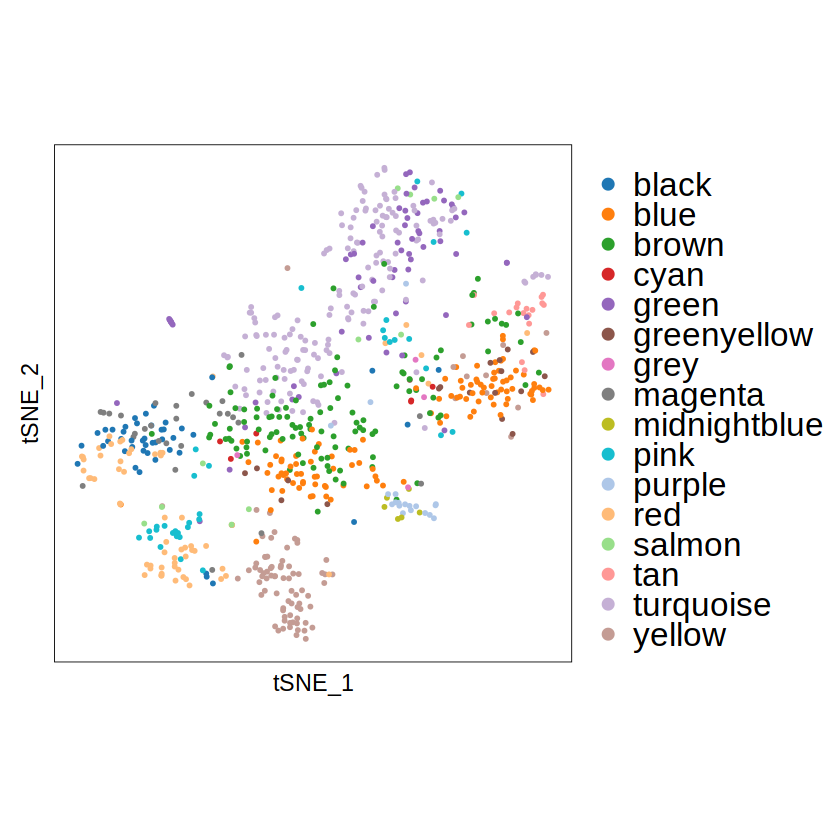

In [384]:
DimPlot(ont_ne, reduction = "tsne", dims = c(1, 2), group.by = "RCA") + scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_TSNE_%d_%d_%s.pdf", 1, 30, "RCA_cluster"), height = 2.8)

## celltype2

In [395]:
ont_ne@meta.data$celltype2 <- as.character(ont_ne@meta.data$celltype1)
ont_ne@meta.data[which(ont_ne@meta.data$`RNA_snn_res.2.5` %in% c(1, 5, 0, 6, 9)), ]$celltype2 <- "Stem/TA"
ont_ne@meta.data[which(ont_ne@meta.data$`RNA_snn_res.2.5` %in% c(10, 4, 2)), ]$celltype2 <- "Immature Goblet"
ont_ne@meta.data[which(ont_ne@meta.data$`RNA_snn_res.2.5` %in% c(7, 12)), ]$celltype2 <- "Goblet"
ont_ne@meta.data[which(ont_ne@meta.data$`RNA_snn_res.2.5` %in% c(3, 8)), ]$celltype2 <- "Enterocyte"
ont_ne@meta.data[which(ont_ne@meta.data$`RNA_snn_res.2.5` %in% c(11)), ]$celltype2 <- "Enteroendocrine"
ont_ne@meta.data$celltype2 <- factor(ont_ne@meta.data$celltype2, levels = c(
  "Stem/TA", "Enterocyte", "Immature Goblet", "Goblet", "Enteroendocrine"
))

In [392]:
table(ont_ne@meta.data$celltype2)


        Stem/TA Immature Goblet          Goblet      Enterocyte Enteroendocrine 
            359             192              84             131              32 

Saving 6.67 x 2.8 in image


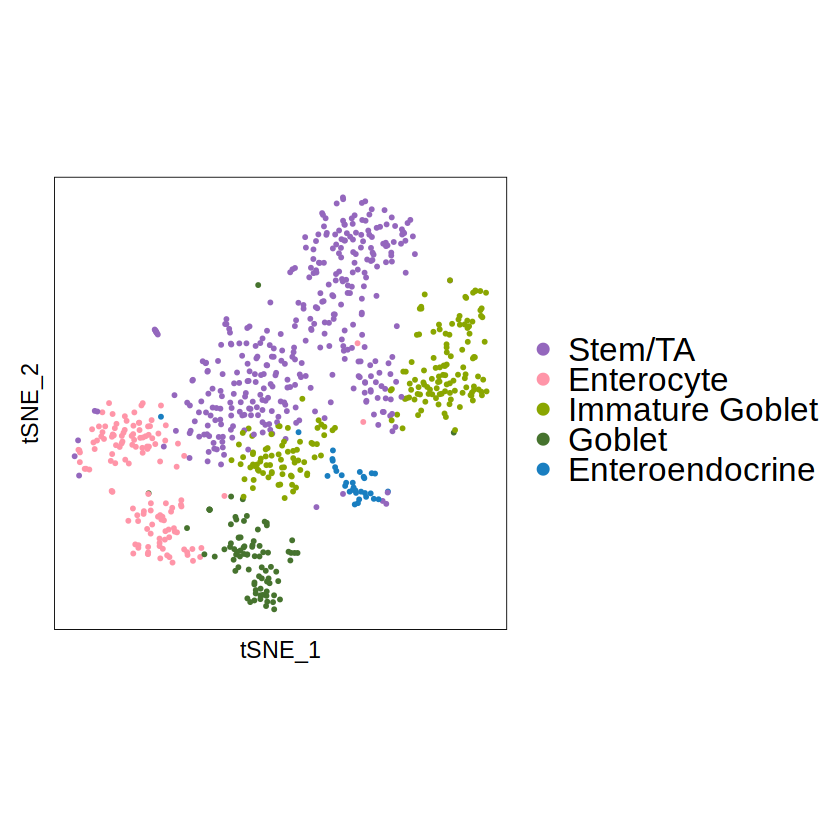

In [396]:
DimPlot(ont_ne, reduction = "tsne", dims = c(1, 2), group.by = "celltype2") + scale_color_manual(values = celltype2_color) + dimplot_theme
ggsave(sprintf("2_ONT_NE_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "celltype2"), height = 2.8)

In [397]:
saveRDS(ont_ne, file = "00_tx_NE_798.rds")

In [399]:
ont@meta.data$celltype2 <- as.character(ont@meta.data$celltype1)
ont@meta.data[ont_ne@meta.data$CellName, ]$celltype2 <- as.character(ont_ne@meta.data$celltype2)
ont@meta.data$celltype2 <- factor(ont@meta.data$celltype2, levels = c(
  "Stem/TA", "Enterocyte", "Immature Goblet", "Goblet", "Enteroendocrine", "Cancer cells"
))
table(ont@meta.data$celltype2)


        Stem/TA      Enterocyte Immature Goblet          Goblet Enteroendocrine 
            359             131             192              84              32 
   Cancer cells 
           2464 

Saving 6.67 x 2.8 in image


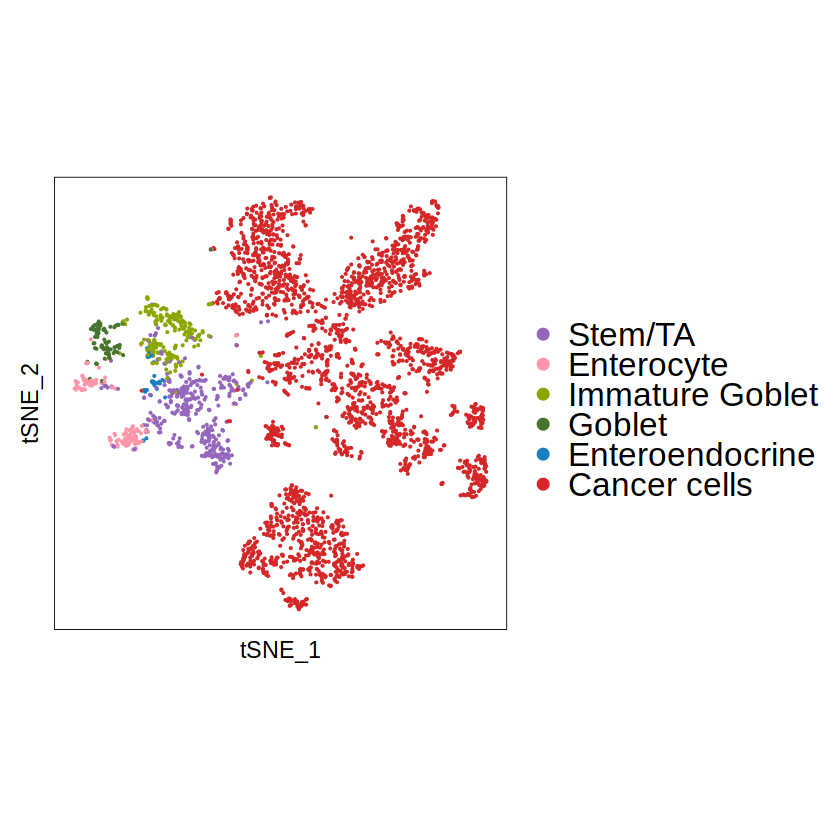

In [400]:
DimPlot(ont, reduction = "tsne", dims = c(1, 2), group.by = "celltype2") + scale_color_manual(values = celltype2_color) + dimplot_theme
ggsave(sprintf("1_ONT_TSNE_%d_%d_%s.pdf", 1, 20, "celltype2"), height = 2.8)

In [401]:
saveRDS(ont, file = "00_tx_5400_3262_hvg1869_PC1_20.rds")

# define cancer cells using normal cells as reference through RCA (celltype3)

In [402]:
ont_cc <- subset(ont, cells = ont@meta.data[which(ont@meta.data$celltype1 %in% "Cancer cells"), ]$CellName)

DefaultAssay(ont_cc) <- "GENE"
ont_cc <- NormalizeData(ont_cc, normalization.method = "LogNormalize", scale.factor = 100000)
ont_cc <- ScaleData(ont_cc, features = rownames(ont_cc))

DefaultAssay(ont_cc) <- "RNA"
ont_cc <- NormalizeData(ont_cc, normalization.method = "LogNormalize", scale.factor = 100000)
ont_cc <- ScaleData(ont_cc, features = rownames(ont_cc))

Centering and scaling data matrix

Centering and scaling data matrix



## select hvg

In [403]:
# select top 1000 highly variable genes from data CRC and HTCRC, respectively
ont_cc_crc <- subset(ont_cc, cells = ont_cc@meta.data[which(ont_cc@meta.data$data %in% "CRC"), ]$CellName)
ont_cc_crc <- NormalizeData(ont_cc_crc, normalization.method = "LogNormalize", scale.factor = 100000)
ont_cc_crc <- FindVariableFeatures(ont_cc_crc, selection.method = "vst", nfeatures = 1000)

ont_cc_htcrc <- subset(ont_cc, cells = ont_cc@meta.data[which(ont_cc@meta.data$data %in% "HTCRC"), ]$CellName)
ont_cc_htcrc <- NormalizeData(ont_cc_htcrc, normalization.method = "LogNormalize", scale.factor = 100000)
ont_cc_htcrc <- FindVariableFeatures(ont_cc_htcrc, selection.method = "vst", nfeatures = 1000)

ont_cc_hvg <- unique(c(VariableFeatures(ont_cc_crc), VariableFeatures(ont_cc_htcrc)))
ont_cc@assays$RNA@var.features <- ont_cc_hvg
length(VariableFeatures(ont_cc))

[1] 1875

PC_ 1 
Positive:  CRIP2-201, ALDOA-215, RAB7A-215, CHGA-201, CHGB-201, SERPINA1-208, RPS2-215, MUC2-202, DKK4-201, SPINK4-201 
	   WFDC2-204, PCSK1N-201, RPL18-201, 7SK.1-201, REG3A-202, SPON2-201, CLCA1-202, ITLN1-201, REG1A-201, MAGEA3-201 
	   TPH1-204, AGT-201, ACTN4-201, DEFA6-201, HEPACAM2-202, LYPD8-201, WFDC2-203, TUBA1A-202, RASD1-201, CALML3-201 
Negative:  HSPD1-202, PDIA6-201, HSPA5-201, EZR-202, CTNNA1-201, TUBB-205, EIF3I-225, CDH17-NIC, VCP-205, DPM1-203 
	   IMMT-207, EZR-NNC, CSDE1-204, HSPA9-201, GPA33-201, HNRNPA1-205, SLCO4A1-201, VCP-206, ACO2-216, GPRC5A-205 
	   CAPN2-201, MISP-201, TM4SF1-201, ZNHIT1-201, SLC2A1-203, OS9-NIC.1, USP10-205, OVOL1-201, MYD88-201, CAPN1-201 
PC_ 2 
Positive:  CHGA-201, CHGB-201, TUBA1A-202, PCSK1N-201, AGT-201, DKK4-201, SPON2-201, MAGEA3-201, SLC1A5-203, RBP1-201 
	   EGR2-201, RARRES2-201, SERPINA1-208, RND1-201, C2-201, STRA6-NNC, HSPA1A-201, ACTN4-201, HSPA2-201, DEPP1-201 
	   RASD1-201, MAGED1-NIC.1, MME-201, EGR1-201, WFS1-20

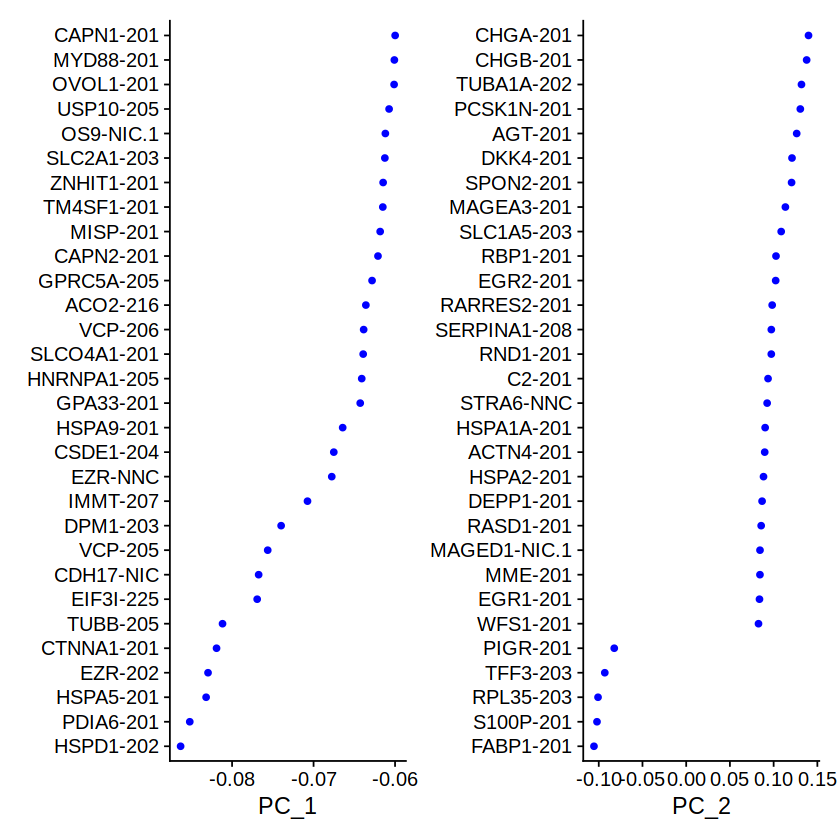

In [404]:
ont_cc <- RunPCA(ont_cc, features = ont_cc_hvg, npcs = 50)
VizDimLoadings(ont_cc, dims = 1:2, reduction = "pca")

Saving 6.67 x 2.8 in image


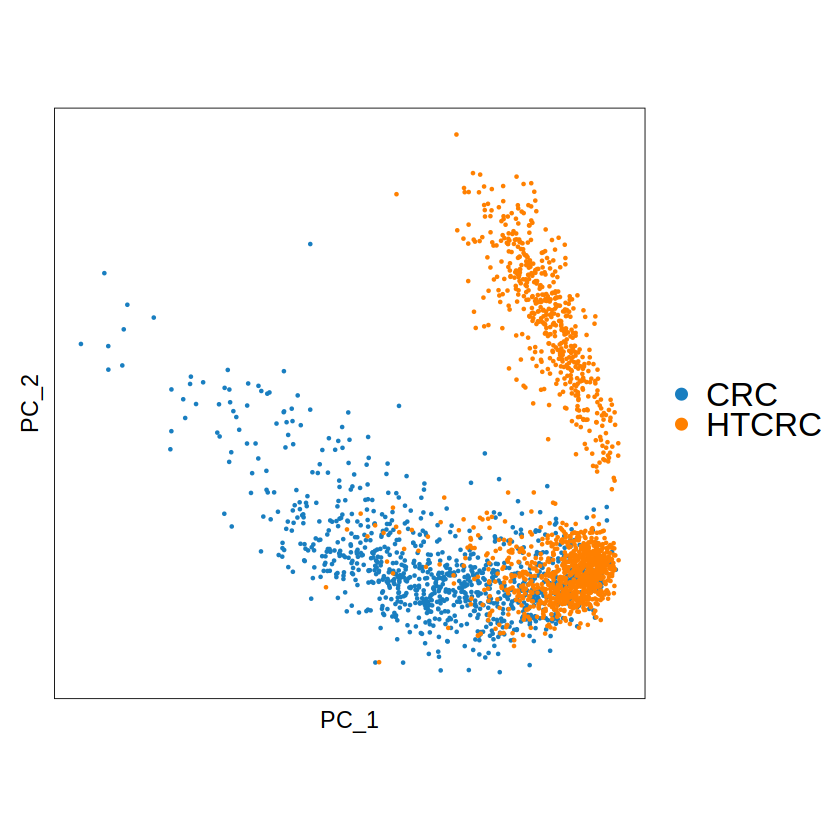

Saving 6.67 x 2.8 in image


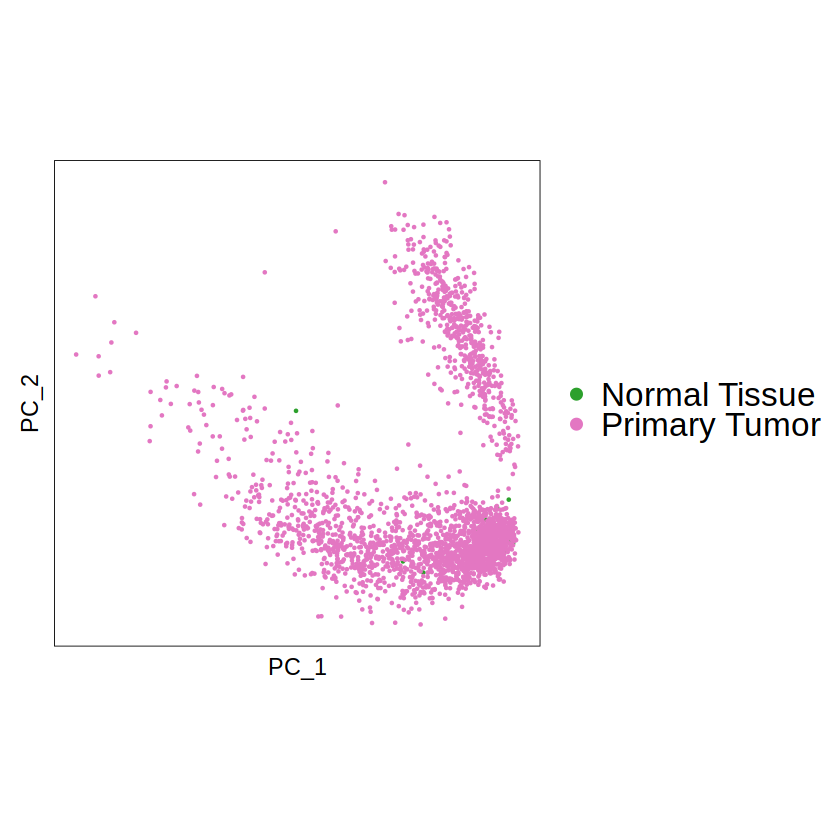

Saving 6.67 x 2.8 in image


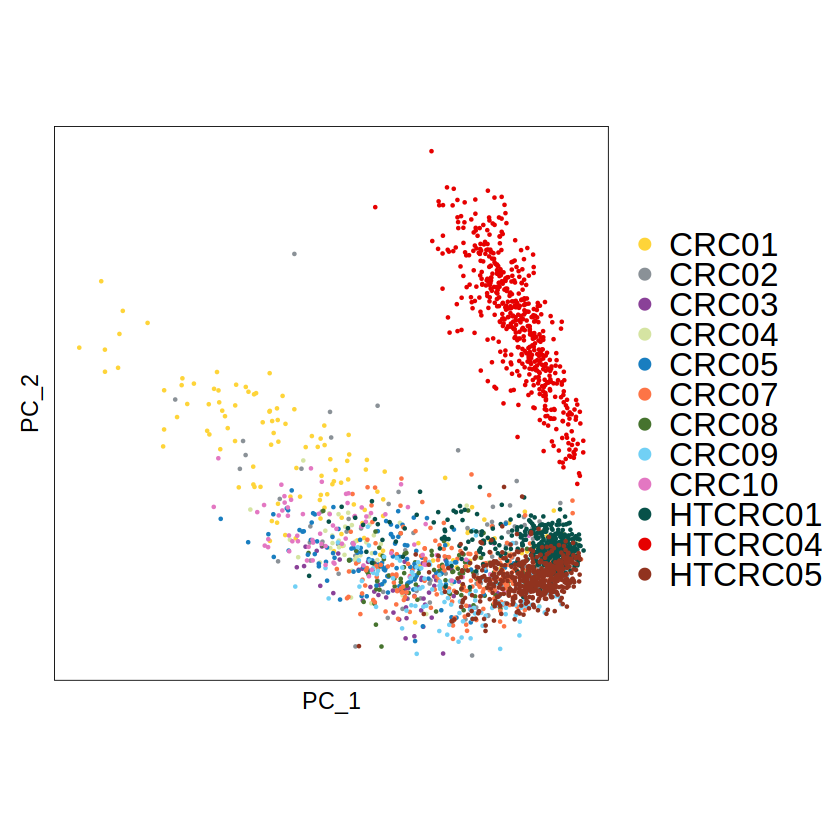

Saving 6.67 x 2.8 in image


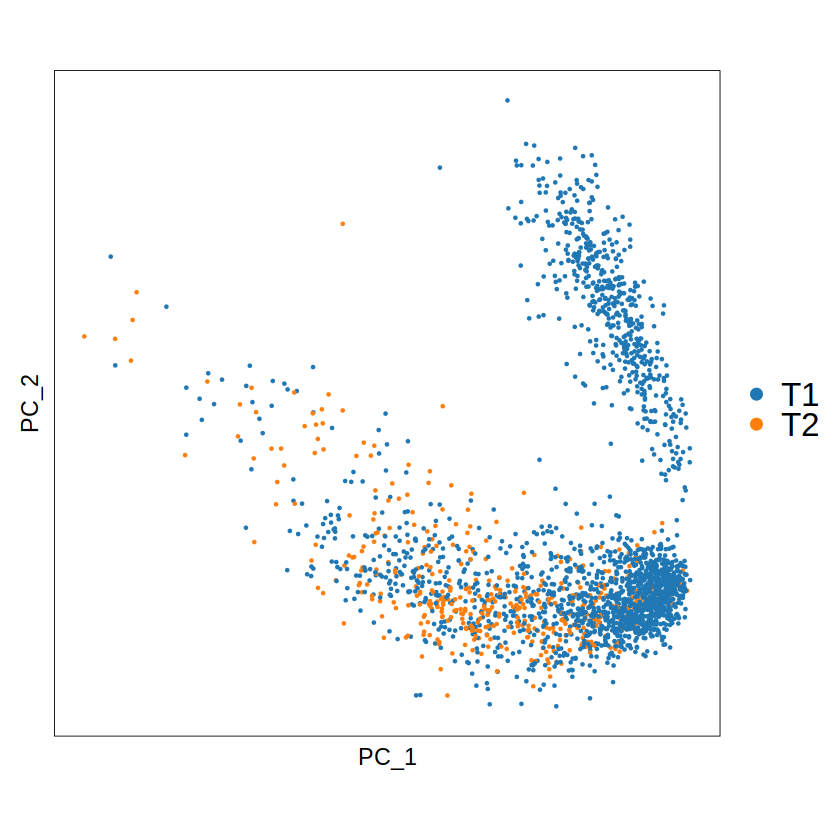

In [405]:
dim_1 <- 1
dim_2 <- 2
DimPlot(ont_cc, reduction = "pca", dims = c(1, 2), group.by = "data") +
  scale_color_manual(values = data_color) + dimplot_theme
ggsave(sprintf("3_ONT_CC_PCA_%d_%d_%s.pdf", dim_1, dim_2, "data"), height = 2.8)

DimPlot(ont_cc, reduction = "pca", dims = c(1, 2), group.by = "Tissue") +
  scale_color_manual(values = tissue_color) + dimplot_theme
ggsave(sprintf("3_ONT_CC_PCA_%d_%d_%s.pdf", dim_1, dim_2, "Tissue"), height = 2.8)

DimPlot(ont_cc, reduction = "pca", dims = c(1, 2), group.by = "patient") +
  scale_color_manual(values = patient_color) + dimplot_theme
ggsave(sprintf("3_ONT_CC_PCA_%d_%d_%s.pdf", dim_1, dim_2, "patient"), height = 2.8)

DimPlot(ont_cc, reduction = "pca", dims = c(1, 2), group.by = "position") +
  scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("3_ONT_CC_PCA_%d_%d_%s.pdf", dim_1, dim_2, "position"), height = 2.8)

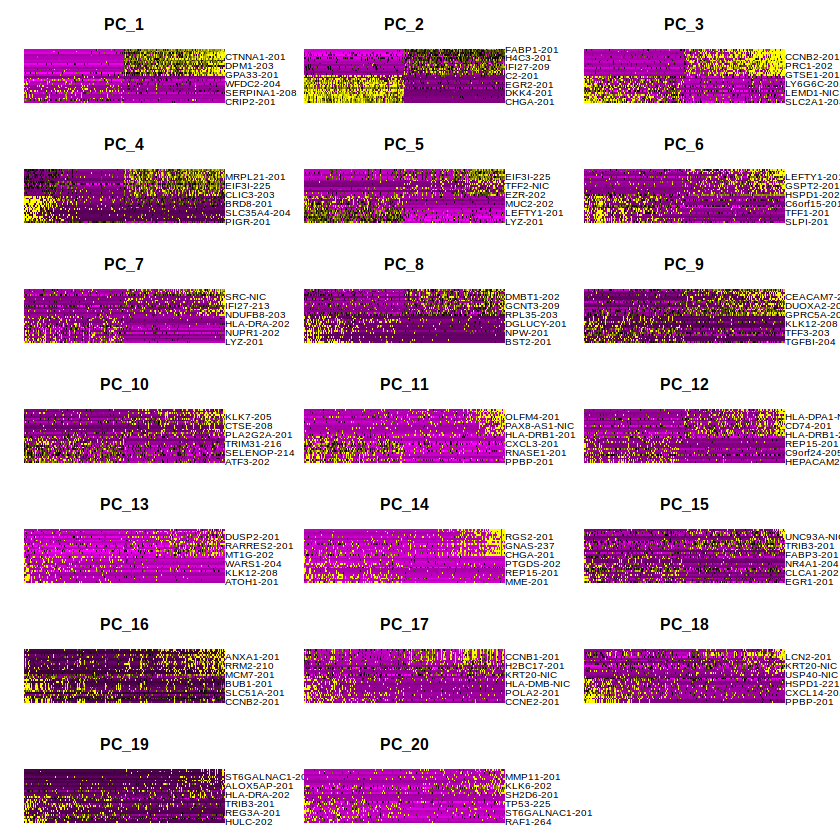

In [406]:
DimHeatmap(ont_cc, dims = 1:20, cells = 500, balanced = TRUE)

Warning message:
“Removed 71567 rows containing missing values (`geom_point()`).”


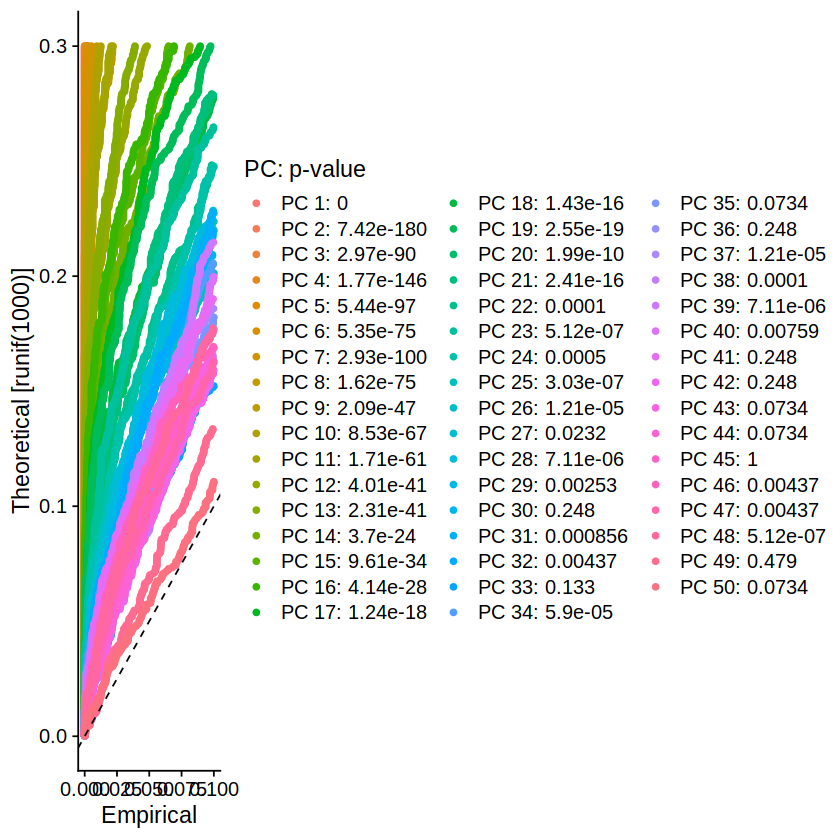

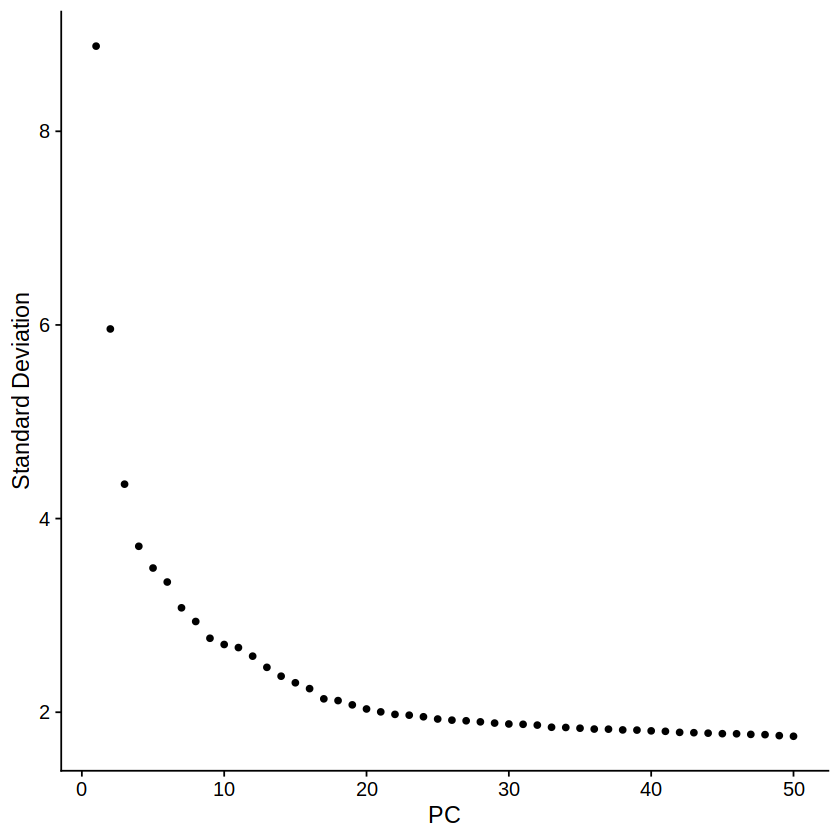

In [407]:
ont_cc <- JackStraw(ont_cc, num.replicate = 200, dims = 50)
ont_cc <- ScoreJackStraw(ont_cc, dims = 1:50)
JackStrawPlot(ont_cc, dims = 1:50)
ElbowPlot(ont_cc, ndims = 50)

## tsne

In [408]:
dim_FindNeighbors_1 <- 1
dim_FindNeighbors_2 <- 20
ont_cc <- FindNeighbors(ont_cc, dims = c(dim_FindNeighbors_1:dim_FindNeighbors_2))

ont_cc <- RunTSNE(ont_cc, dims = dim_FindNeighbors_1:dim_FindNeighbors_2)
ont_cc <- RunUMAP(ont_cc, dims = dim_FindNeighbors_1:dim_FindNeighbors_2)

Computing nearest neighbor graph

Computing SNN

17:01:20 UMAP embedding parameters a = 0.9922 b = 1.112

17:01:20 Read 2464 rows and found 20 numeric columns

17:01:20 Using Annoy for neighbor search, n_neighbors = 30

17:01:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:01:20 Writing NN index file to temp file /tmp/Rtmp2TlcYy/file6f73ea32339

17:01:20 Searching Annoy index using 1 thread, search_k = 3000

17:01:21 Annoy recall = 100%

17:01:22 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:01:25 Initializing from normalized Laplacian + noise (using irlba)

17:01:25 Commencing optimization for 500 epochs, with 99866 positive edges

17:01:34 Optimization finished



Saving 6.67 x 2.8 in image


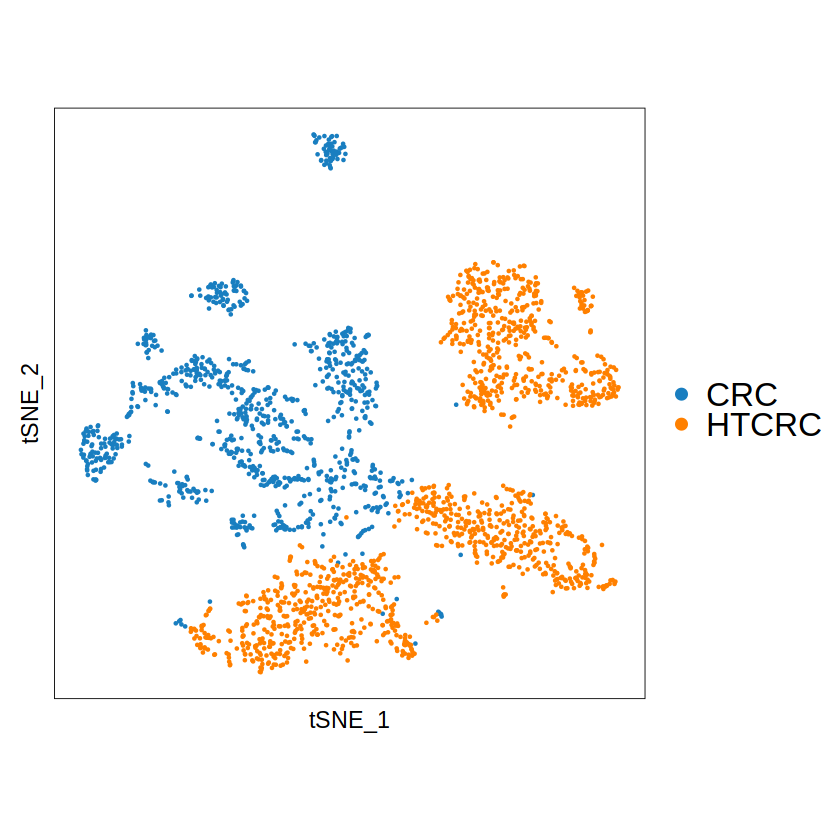

Saving 6.67 x 2.8 in image


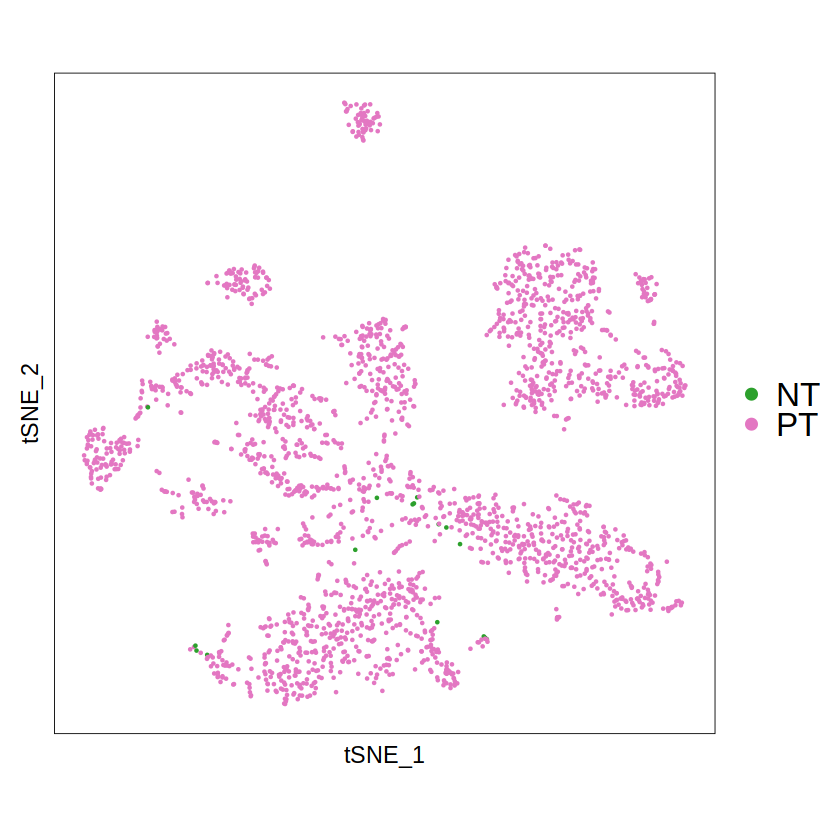

Saving 6.67 x 2.8 in image


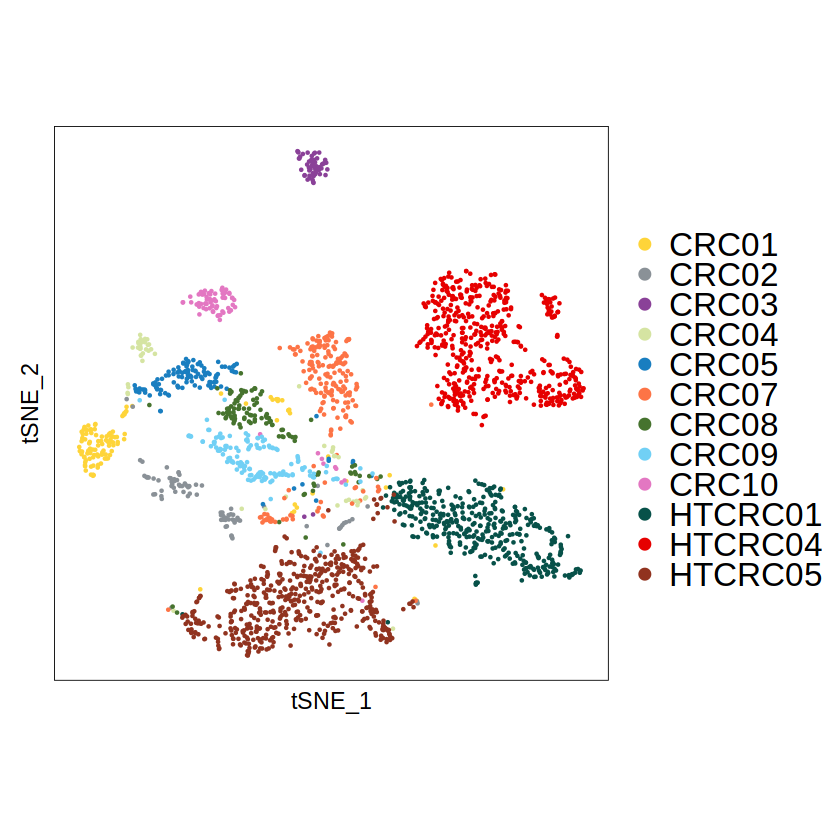

Saving 6.67 x 2.8 in image


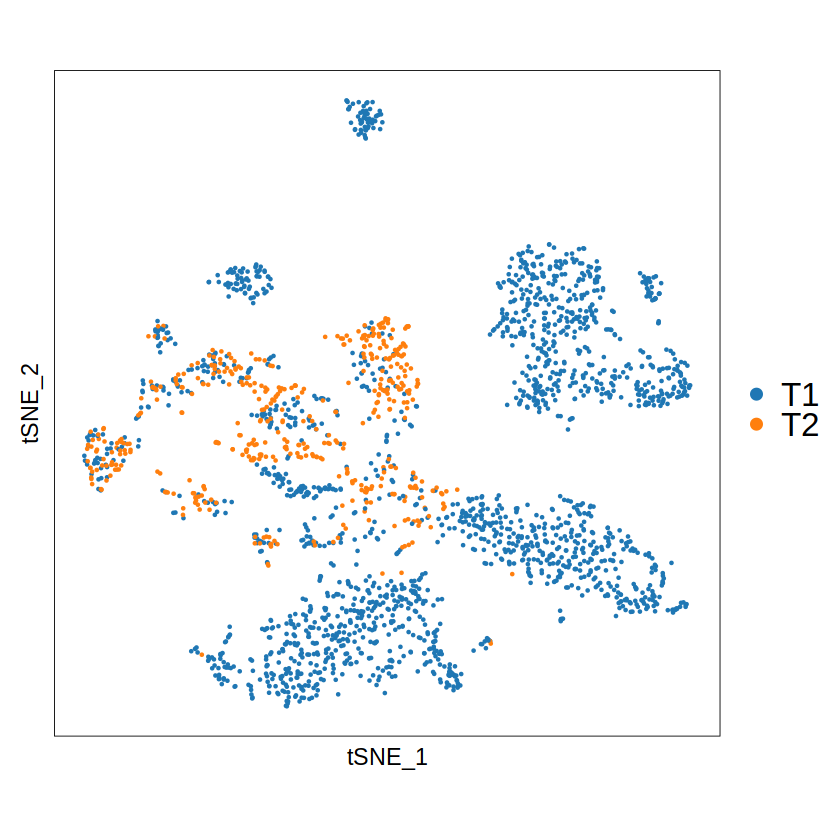

Saving 6.67 x 2.8 in image


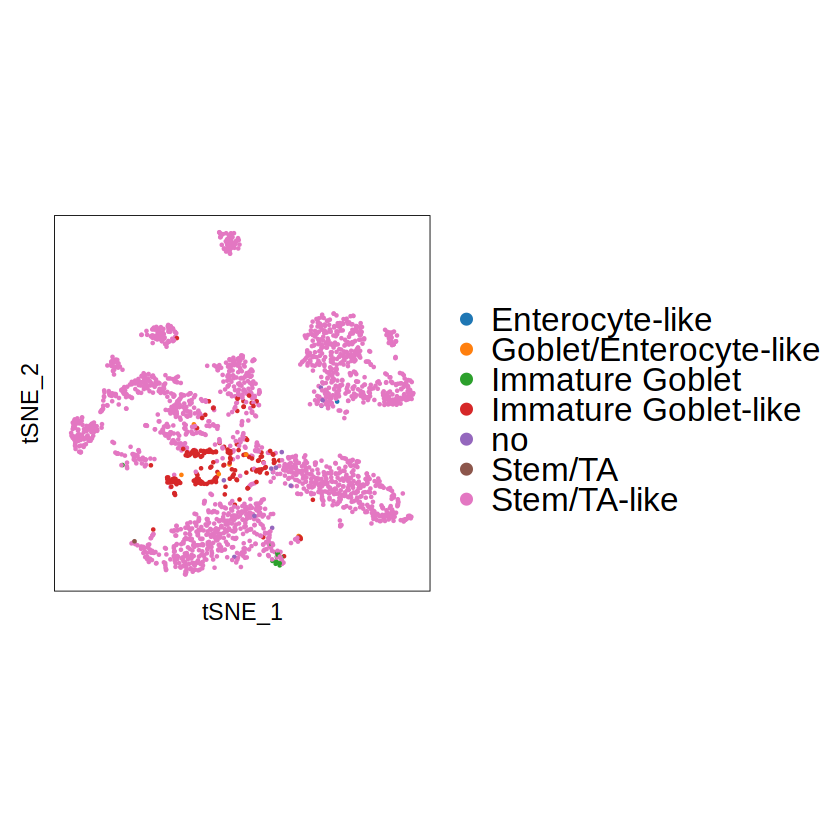

In [409]:
DimPlot(ont_cc, reduction = "tsne", dims = c(1, 2), group.by = "data") +
  scale_color_manual(values = data_color) + dimplot_theme
ggsave(sprintf("3_ONT_CC_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "data"), height = 2.8)

DimPlot(ont_cc, reduction = "tsne", dims = c(1, 2), group.by = "tissue") +
  scale_color_manual(values = tissue_color) + dimplot_theme
ggsave(sprintf("3_ONT_CC_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "tissue"), height = 2.8)

DimPlot(ont_cc, reduction = "tsne", dims = c(1, 2), group.by = "patient") +
  scale_color_manual(values = patient_color) + dimplot_theme
ggsave(sprintf("3_ONT_CC_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "patient"), height = 2.8)

DimPlot(ont_cc, reduction = "tsne", dims = c(1, 2), group.by = "position") +
  scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("3_ONT_CC_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "position"), height = 2.8)

DimPlot(ont_cc, reduction = "tsne", dims = c(1, 2), group.by = "celltype_old") +
  scale_color_manual(values = color) + dimplot_theme
ggsave(sprintf("3_ONT_CC_TSNE_%d_%d_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, "celltype_old"), height = 2.8)

In [410]:
for (i in c(0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6)) {
  ont_cc <- FindClusters(ont_cc, resolution = i)
}
# plot resolution
for (myres in c(0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3)) {
  DimPlot(ont_cc, reduction = "tsne", dims = c(1, 2), group.by = sprintf("RNA_snn_res.%s", myres), label = T) + dimplot_theme + guides(col = guide_legend(ncol = 1))
  ggsave(sprintf("3_ONT_CC_TSNE_%s_%s_res_%s.pdf", dim_FindNeighbors_1, dim_FindNeighbors_2, myres), height = 2.8)
}

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2464
Number of edges: 88325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9614
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2464
Number of edges: 88325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9409
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2464
Number of edges: 88325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9236
Number of communities: 9
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2464
Number of edges: 88325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9083
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer ve

Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image
Saving 6.67 x 2.8 in image


## featureplot-gene

In [411]:
DefaultAssay(ont_cc) <- "GENE"

In [412]:
marker <- read.table(file = "../../marker/crc_marker_v3.txt", header = T, sep = "\t")
length(marker$GeneName)
length(unique(marker$GeneName))
length(intersect(rownames(GetAssayData(object = ont_cc, slot = "counts")), unique(marker$GeneName)))

[1] 322

[1] 219

[1] 155

In [413]:
for (event in names(table(marker$event1))) {
  mymarker <- marker[which(marker$event1 %in% event), ]$GeneName
  gene <- intersect(mymarker, rownames(GetAssayData(object = ont_cc, slot = "counts")))
  gene <- sort(gene)
  print(c(event, gene))
  for (g in gene) {
    FeaturePlot(ont_cc, features = g, reduction = "tsne", ncol = 1) + featureplot_theme
    ggsave(sprintf("3_ONT_CC_featureplot_gene/3_featureplot_tsne_%s_%s.pdf", event, g), height = 3.5, width = 4, limitsize = FALSE)
  }
}

[1] "B cells" "DERL3"  
[1] "blood" "HBA1"  "HBA2" 
[1] "Bottom crypt" "ASCL2"        "OLFM4"       
[1] "DC"   "CST3" "LYZ" 
[1] "endothelial" "ENG"        
 [1] "enterocyte" "ANPEP"      "AQP8"       "CA1"        "CA2"       
 [6] "CDH1"       "CDX2"       "CLCA4"      "FABP1"      "FABP2"     
[11] "GUCA2B"     "KRT20"      "SLC26A2"    "SLC26A3"    "TMEM37"    
[1] "enteroendocrine" "CHGA"            "CHGB"            "NEUROD1"        
[5] "PROX1"           "PYY"             "REG4"           
[1] "epithelial" "CDH1"       "CLDN4"      "CLDN7"      "EPCAM"     
[6] "KRT19"      "KRT20"     
[1] "fibroblast"
 [1] "G1_S"     "ATAD2"    "BLM"      "BRIP1"    "CASP8AP2" "CCNE2"   
 [7] "CDC45"    "CDC6"     "CDCA7"    "CENPU"    "CHAF1B"   "DSCC1"   
[13] "DTL"      "E2F8"     "EXO1"     "FEN1"     "GINS2"    "GMNN"    
[19] "HELLS"    "MCM2"     "MCM4"     "MCM6"     "MSH2"     "NASP"    
[25] "PCNA"     "POLA1"    "POLD3"    "PRIM1"    "RAD51"    "RAD51AP1"
[31] "RPA2"     "RRM1"     

## featureplot-tx

In [414]:
DefaultAssay(ont_cc) <- "RNA"

In [415]:
tx_info <- read.table(file = "../../CRC_HTCRC_00_gene_isoform_info/00_corrected_ref_TranID_TranName_GeneName_structural_category.txt", header = T, sep = "\t")
head(tx_info, 1)

TranID          TranName  GeneName GeneID          structural_category
1 ENST00000562695 MOSMO-204 MOSMO    ENSG00000185716 FSM                
  subcategory    
1 reference_match

In [416]:
marker <- read.table(file = "../../marker/crc_marker_v3.txt", header = T, sep = "\t")
marker <- merge(marker[, c("GeneName", "event1")], tx_info[, c("GeneName", "TranName")], by = "GeneName", all.x = T)
marker <- marker[!duplicated(marker), ]
marker <- marker[!is.na(marker$TranName), ]
dim(marker)

[1] 324   3

In [417]:
for (event in names(table(marker$event1))) {
  mymarker <- marker[which(marker$event1 %in% event), ]$TranName
  tx <- intersect(mymarker, rownames(GetAssayData(object = ont_cc, slot = "counts")))
  tx <- sort(tx)
  print(c(event, tx))
  for (t in tx) {
    FeaturePlot(ont_cc, features = t, reduction = "tsne", ncol = 1) + featureplot_theme
    ggsave(sprintf("3_ONT_CC_featureplot_tx/3_featureplot_tsne_%s_%s.pdf", event, t), height = 3.5, width = 4, limitsize = FALSE)
  }
}

[1] "B cells"   "DERL3-202" "DERL3-204" "DERL3-208"
[1] "blood"    "HBA1-201" "HBA1-203" "HBA2-201"
[1] "Bottom crypt" "ASCL2-201"    "OLFM4-201"   
[1] "DC"       "CST3-201" "CST3-203" "LYZ-201"  "LYZ-203" 
[1] "endothelial" "ENG-202"    
 [1] "enterocyte"  "ANPEP-201"   "ANPEP-210"   "AQP8-201"    "CA1-204"    
 [6] "CA1-223"     "CA1-NIC"     "CA2-201"     "CA2-202"     "CA2-204"    
[11] "CDH1-204"    "CDH1-NIC"    "CDX2-201"    "CDX2-202"    "CLCA4-201"  
[16] "FABP1-201"   "FABP1-NIC"   "FABP2-201"   "GUCA2B-201"  "KRT20-NIC"  
[21] "SLC26A2-201" "SLC26A3-203" "TMEM37-201" 
 [1] "enteroendocrine" "CHGA-201"        "CHGB-201"        "NEUROD1-201"    
 [5] "PROX1-203"       "PROX1-204"       "PROX1-205"       "PYY-203"        
 [9] "REG4-201"        "REG4-203"       
 [1] "epithelial" "CDH1-204"   "CDH1-NIC"   "CLDN4-201"  "CLDN4-203" 
 [6] "CLDN7-201"  "CLDN7-202"  "CLDN7-207"  "EPCAM-201"  "EPCAM-203" 
[11] "KRT19-201"  "KRT19-204"  "KRT19-205"  "KRT19-207"  "KRT20-NIC" 
 [1] "G1

## RCA: cancer cells

In [418]:
ne_panel <- data.frame(
  `Stem_TA` = rowMeans(ont_ne@assays$GENE@data[, which(
    colnames(ont_ne@assays$GENE@data) %in%
      ont_ne@meta.data[which(ont_ne@meta.data$celltype2 %in% "Stem/TA"), ]$CellName
  )]),
  Enterocyte = rowMeans(ont_ne@assays$GENE@data[, which(
    colnames(ont_ne@assays$GENE@data) %in%
      ont_ne@meta.data[which(ont_ne@meta.data$celltype2 %in% "Enterocyte"), ]$CellName
  )]),
  ImmatureGoblet = rowMeans(ont_ne@assays$GENE@data[, which(
    colnames(ont_ne@assays$GENE@data) %in%
      ont_ne@meta.data[which(ont_ne@meta.data$celltype2 %in% "Immature Goblet"), ]$CellName
  )]),
  Goblet = rowMeans(ont_ne@assays$GENE@data[, which(
    colnames(ont_ne@assays$GENE@data) %in%
      ont_ne@meta.data[which(ont_ne@meta.data$celltype2 %in% "Goblet"), ]$CellName
  )]),
  Enteroendocrine = rowMeans(ont_ne@assays$GENE@data[, which(
    colnames(ont_ne@assays$GENE@data) %in%
      ont_ne@meta.data[which(ont_ne@meta.data$celltype2 %in% "Enteroendocrine"), ]$CellName
  )])
)

In [420]:
saveRDS(ne_panel, file = "3_CC_RCA_panel_is_NE_798cells.rds")

In [435]:
library(RCAv2)

RCA_cc <- RCAv2::createRCAObject(ont_cc@assays$GENE@counts, ont_cc@assays$GENE@data)
RCA_cc <- RCAv2::dataProject(rca.obj = RCA_cc, method = "Custom", customPath = "3_CC_RCA_panel_is_NE_798cells.rds", corMeth = "pearson")
RCA_cc <- RCAv2::dataClust(RCA_cc, deepSplitValues = 1.5, minClustSize = 2)

 ..cutHeight not given, setting it to 1.33  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [436]:
RCAv2::plotRCAHeatmap(RCA_cc, filename = "3_CC_RCA_heatmap_deepSplitValues1.5.pdf", var.thrs = 0)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

In [441]:
ont_cc@meta.data$RCA <- RCA_cc$clustering.out$dynamicColorsList$`deepSplit 1.5`

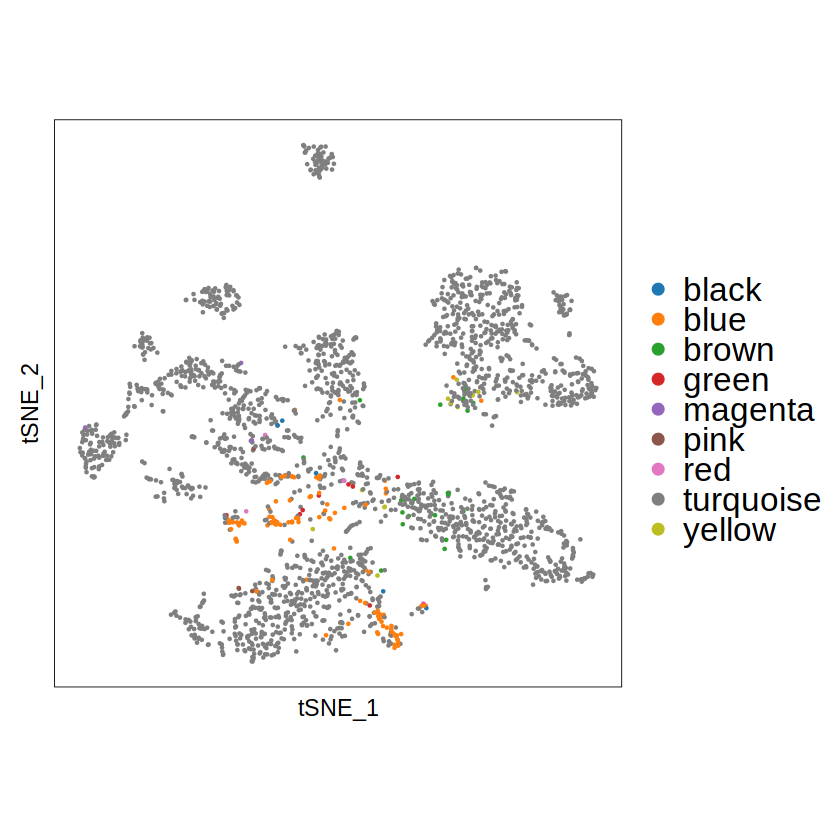

In [442]:
DimPlot(ont_cc, reduction = "tsne", dims = c(1, 2), group.by = "RCA") + scale_color_manual(values = color) + dimplot_theme

In [445]:
ont_cc@meta.data$celltype3 <- "other"
ont_cc@meta.data$celltype3 <- RCA_cc$clustering.out$dynamicColorsList$`deepSplit 1.5`

ont_cc@meta.data[which(ont_cc@meta.data$celltype3 %in% c("turquoise", "black", "brown")), ]$celltype3 <- "Stem/TA-like"
ont_cc@meta.data[which(ont_cc@meta.data$celltype3 %in% c("blue")), ]$celltype3 <- "Immature Goblet-like"
ont_cc@meta.data[which(ont_cc@meta.data$celltype3 %in% c("magenta", "pink")), ]$celltype3 <- "Enteroendocrine-like"
ont_cc@meta.data[which(ont_cc@meta.data$celltype3 %in% c("red", "green")), ]$celltype3 <- "Goblet-like"
ont_cc@meta.data$celltype3 <- factor(ont_cc@meta.data$celltype3, levels = c("Stem/TA-like", "Immature Goblet-like", "Enteroendocrine-like", "Goblet-like"))

table(ont_cc@meta.data$celltype3)


        Stem/TA-like Immature Goblet-like Enteroendocrine-like 
                2313                  115                    7 
         Goblet-like 
                  16 

In [469]:
ont_cc@meta.data$celltype3 <- "other"
ont_cc@meta.data$celltype3 <- RCA_cc$clustering.out$dynamicColorsList$`deepSplit 1.5`

ont_cc@meta.data[which(ont_cc@meta.data$celltype3 %in% c("turquoise", "black", "brown", "magenta", "pink")), ]$celltype3 <- "Stem/TA-like"
ont_cc@meta.data[which(ont_cc@meta.data$celltype3 %in% c("blue", "green")), ]$celltype3 <- "Immature Goblet-like"
ont_cc@meta.data[which(ont_cc@meta.data$celltype3 %in% c("yellow")), ]$celltype3 <- "Enteroendocrine-like"
ont_cc@meta.data[which(ont_cc@meta.data$celltype3 %in% c("red")), ]$celltype3 <- "Goblet-like"
ont_cc@meta.data$celltype3 <- factor(ont_cc@meta.data$celltype3, levels = c("Stem/TA-like", "Immature Goblet-like", "Goblet-like", "Enteroendocrine-like"))

table(ont_cc@meta.data$celltype3)


        Stem/TA-like Immature Goblet-like          Goblet-like 
                2320                  125                    6 
Enteroendocrine-like 
                  13 

In [474]:
saveRDS(ont_cc, file = "00_tx_CC_2464.rds")

In [449]:
rca <- as.data.frame(RCA_cc$projection.data)
# rca
rownames(rca) <- c("Stem/TA", "Enterocyte", "Immature Goblet", "Goblet", "Enteroendocrine")

In [470]:
annotation_col <- ont_cc@meta.data[, "celltype3", drop = F]
names(annotation_col) <- "CellType"

ann_colors <- list(
  CellType = c(
    `Stem/TA-like` = celltype3_color[6], `Immature Goblet-like` = celltype3_color[7],
    `Goblet-like` = celltype3_color[8], `Enteroendocrine-like` = celltype3_color[9]
  )
)

In [471]:
pheatmap(
  rca,
  color = colorRampPalette(c("blue", "white", "red"))(100), cluster_cols = RCA_cc$clustering.out$cellTree, cluster_rows = T, show_col = F,
  annotation_col = annotation_col, annotation_colors = ann_colors, file = "3_CC_RCA_CancerCells_heatmap.pdf", cellheight = 16, height = 2.5, width = 8
)

In [472]:
ont@meta.data$celltype3 <- as.character(ont@meta.data$celltype2)
ont@meta.data[ont_cc@meta.data$CellName, ]$celltype3 <- as.character(ont_cc@meta.data$celltype3)
# table(ont@meta.data$celltype3)
ont@meta.data$celltype3 <- factor(ont@meta.data$celltype3, levels = c(
  "Stem/TA", "Enterocyte", "Immature Goblet", "Goblet", "Enteroendocrine",
  "Stem/TA-like", "Immature Goblet-like", "Goblet-like", "Enteroendocrine-like"
))
table(ont@meta.data$celltype3)


             Stem/TA           Enterocyte      Immature Goblet 
                 359                  131                  192 
              Goblet      Enteroendocrine         Stem/TA-like 
                  84                   32                 2320 
Immature Goblet-like          Goblet-like Enteroendocrine-like 
                 125                    6                   13 

Saving 6.67 x 3.5 in image


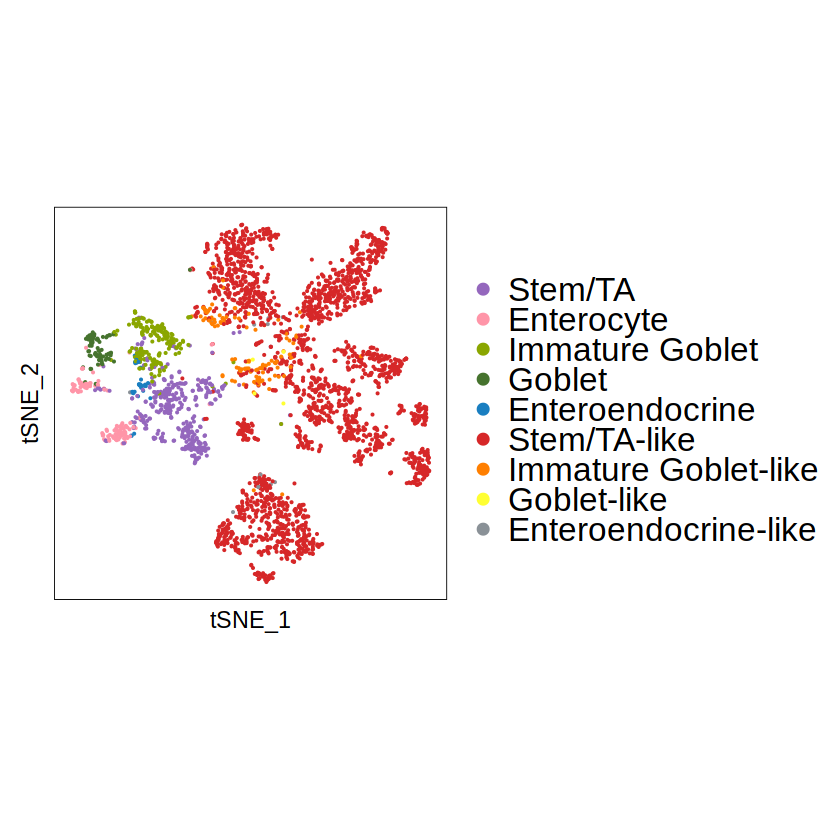

In [473]:
DimPlot(ont, reduction = "tsne", dims = c(1, 2), group.by = "celltype3") + scale_color_manual(values = celltype3_color) + dimplot_theme #+ theme(legend.position = "top")
ggsave(sprintf("1_ONT_TSNE_1_20_celltype3.pdf"), height = 3.5)

In [475]:
saveRDS(ont, file = "00_tx_5400_3262_hvg1869_PC1_20.rds")

In [476]:
ont_2736 <- subset(ont, cells = ont@meta.data[-which(ont@meta.data$patient %in% "HTCRC04" & ont@meta.data$celltype1 %in% "Cancer cells"), ]$CellName)
ont_2736
saveRDS(ont_2736, file = "00_tx_5400_3262_hvg1869_PC1_20_removeHTCRC04CancerCells526_2736cells.rds")

An object of class Seurat 
42256 features across 2736 samples within 2 assays 
Active assay: GENE (12827 features, 0 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, tsne, umap

# Cell type ratio

In [477]:
type_ratio <- as.data.frame(table(ont@meta.data$patient, ont@meta.data$celltype3))

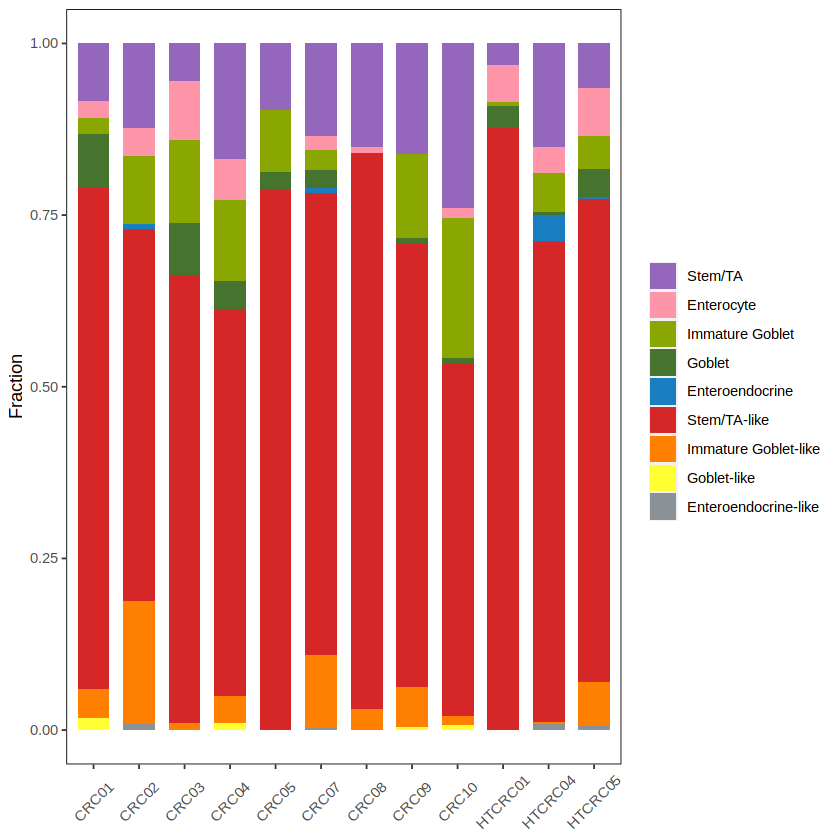

In [478]:
type_ratio <- as.data.frame(table(ont@meta.data$patient, ont@meta.data$celltype3))
ggplot(type_ratio, aes(x = Var1, y = Freq, fill = Var2)) +
  geom_bar(stat = "identity", position = "fill", width = 0.7) +
  mytheme +
  scale_fill_manual(values = celltype3_color) +
  labs(y = "Fraction") +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5), legend.title = element_blank(), axis.title.x = element_blank())
ggsave("1_celltype3_ratio.pdf", height = 3, width = 5)

# Dotplot of marker genes

In [479]:
DefaultAssay(ont) <- "GENE"

In [488]:
marker_gene <- c(
  "LEFTY1", "CD24", "OLFM4", "SOX9", "LCN2", "EPHB3", "PLA2G2A", "HMGB2", "RGMB", # Stem/TA
  "PCNA", # TA
  "AQP8", "GUCA2B", "TMIGD1", "FABP1", "ANPEP", "CLCA4", "SLC26A2", # Enterocyte
  "CLCA1", "ITLN1", "SPINK4", "SPDEF", "LRRC26", # Immature Goblet
  "TFF3", "MUC2", "ZG16", "BCAS1", "MUC1", "TFF1", # Goblet
  "PYY", "CHGA"
)
marker_gene <- rev(c(
  "LEFTY1", "OLFM4", "LCN2", "PLA2G2A", "CD24", # Stem/TA
  "AQP8", "GUCA2B", "FABP1", # Enterocyte
  "CLCA1", "ITLN1", "LRRC26", #' SPINK4',#"SPDEF",# Immature Goblet
  "TFF3", "ZG16", "TFF1", "MUC1", # , "MUC2", 'MUC1' # Goblet
  "PYY", "CHGA"
))

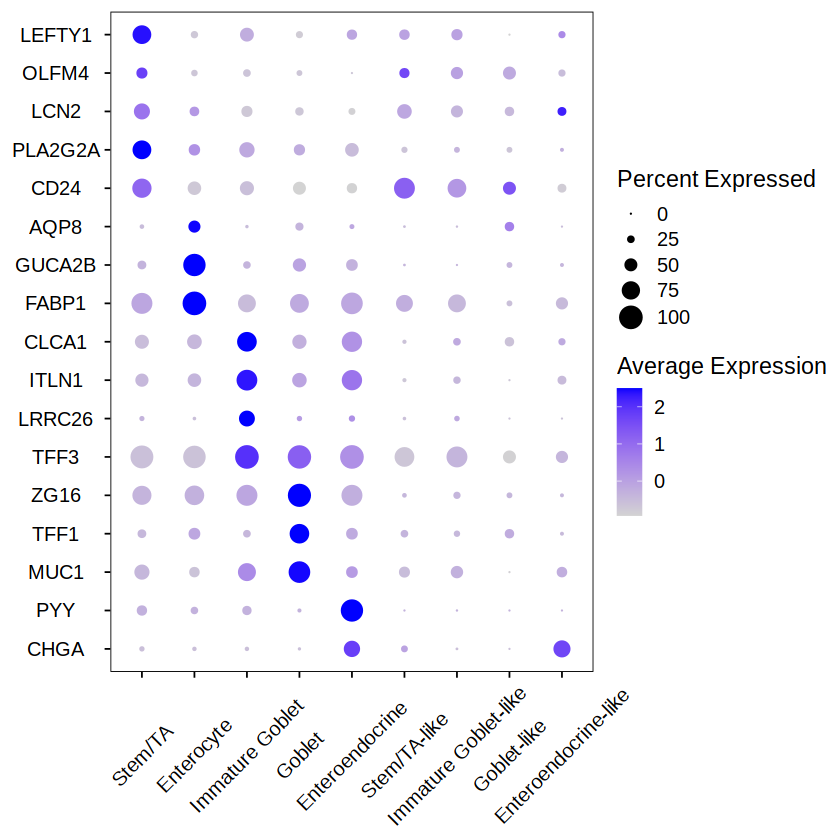

In [496]:
DefaultAssay(ont) <- "GENE"
DotPlot(ont, features = marker_gene, group.by = "celltype3") + RotatedAxis() + coord_flip() + mytheme +
  theme(
    axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5), axis.title = element_blank(),
    axis.text.y = element_text(angle = 360, vjust = 0.5, hjust = 0.5)
  ) # + theme(panel.background = element_rect(fill = alpha('red',0.05)))
ggsave(file = "4_dotplot_marker_gene.pdf", height = 6, width = 4.8)

In [492]:
info <- read.table(file = "../../CRC_HTCRC_00_gene_isoform_info/00_corrected_ref_TranID_TranName_GeneName_structural_category_expression_proportion_rank.txt", header = T, sep = "\t")
marker_iso <- info[which(info$GeneName %in% marker_gene), c("GeneName", "TranName")]
marker_iso$GeneName <- factor(marker_iso$GeneName, levels = marker_gene)
marker_iso <- marker_iso[order(marker_iso$GeneName), ]

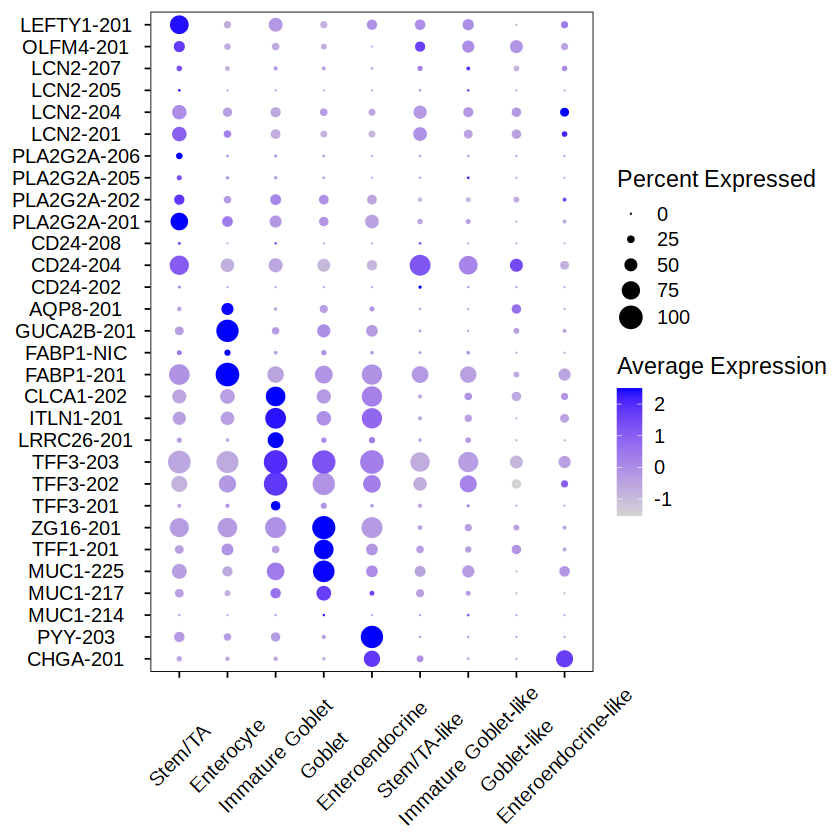

In [493]:
DefaultAssay(ont) <- "RNA"
DotPlot(ont, features = marker_iso$TranName, group.by = "celltype3") + RotatedAxis() + coord_flip() + mytheme +
  theme(
    axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5), axis.title = element_blank(),
    axis.text.y = element_text(angle = 360, vjust = 0.5, hjust = 0.5)
  ) # + theme(panel.background = element_rect(fill = alpha('red',0.05)))
ggsave(file = "4_dotplot_marker_iso.pdf", height = 7, width = 6)

In [494]:
for (g in marker_iso$TranName) {
  VlnPlot(ont, features = g, group.by = "celltype3", pt.size = 0) + scale_fill_manual(values = celltype3_color) + mytheme +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0), axis.title.x = element_blank()) + theme_void() + NoLegend()
  ggsave(sprintf("vlnplot/vlnplot_%s.pdf", g), height = 1, width = 8)
}

# Expression of splicing factor

In [24]:
ont <- readRDS(file = "00_tx_5400_3262_hvg1869_PC1_20.rds")

In [29]:
DefaultAssay(ont) <- "GENE"

In [25]:
library(reshape2)

In [33]:
# Try 3 kinds of sets for splicing factors
sf <- read.table(file = "../../marker/total.txt", header = F)
sf <- sf$V1
sf <- intersect(sf, rownames(ont@assays$GENE@data))
length(sf)

test <- read.csv(file = "../../marker/SplicingFactor_science_2024_Juan.csv", header = T, check.names = F)
sf <- test$Gene.Symbol
length(sf)

marker <- read.csv(file = "../../marker/CRC_import_geneset_V1.csv", header = T)
sf <- marker[!is.na(marker$SF), ]$GeneName
length(sf)

[1] 304

In [45]:
summary(ont@assays$GENE@data@x)
quantile(ont@assays$GENE@data@x, c(1 / 3, 2 / 3))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.9298  1.9050  2.0646  2.9659 11.0079 

33.33333% 66.66667% 
 1.265447  2.576593

In [46]:
expm1(1.26544741295393) * 10
expm1(2.57659267327601) * 10

[1] 25.44678

[1] 121.5225

In [48]:
onethird <- 25
twothirds <- 120

In [51]:
df_sf <- as.data.frame(ont@assays$GENE@data[sf, ])
df_sf <- data.frame(
  `None` = colSums(df_sf == 0),
  `Low` = colSums(df_sf > 0 & df_sf <= log(onethird / 10 + 1)),
  `Medium` = colSums(df_sf > log(onethird / 10 + 1) & df_sf <= log(twothirds / 10 + 1)),
  `High` = colSums(df_sf > log(twothirds / 10 + 1)), check.names = F
)
all(rownames(df_sf) == ont$CellName)
df_sf$celltype1 <- ont$celltype1

df_sf_melt <- melt(df_sf, id.vars = c("celltype1"))

[1] TRUE

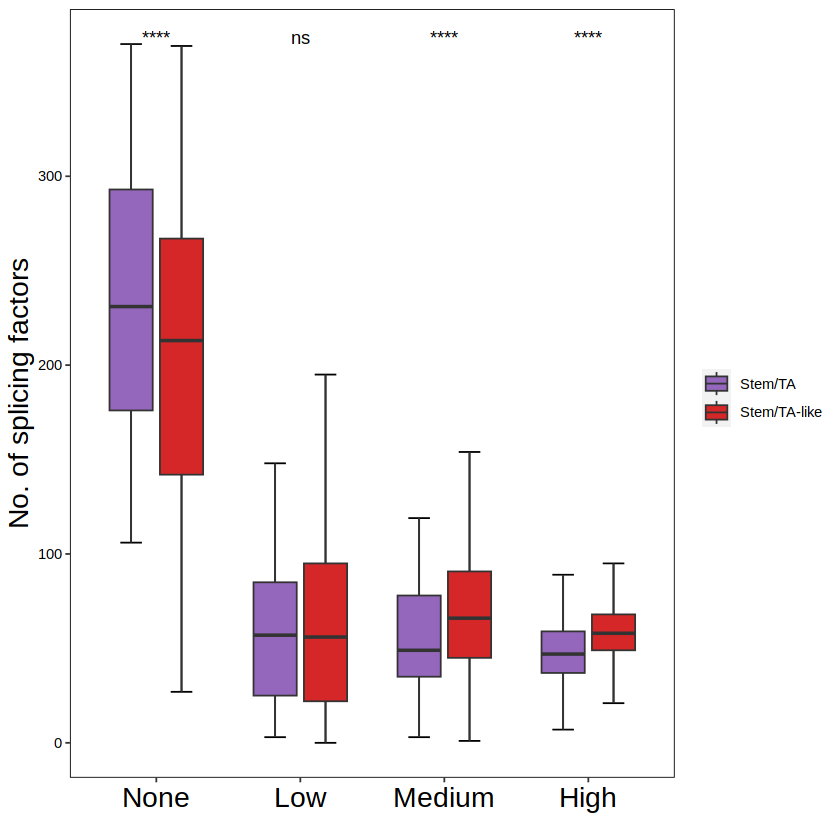

In [323]:
ggplot(data = df_sf_melt, aes(x = variable, y = value, fill = celltype1)) +
  stat_boxplot(geom = "errorbar", linetype = 1, color = "black", position = position_dodge(width = 0.7), width = 0.3) +
  geom_boxplot(outlier.shape = NA, position = position_dodge(width = 0.7), width = 0.6) +
  stat_compare_means(aes(label = ..p.signif..), method = "wilcox.test") +
  scale_fill_manual(values = celltype3_color[c(1, 6)]) +
  labs(x = "", y = "No. of splicing factors") +
  mytheme +
  theme(
    axis.text.x = element_text(size = 17, vjust = 0.5, color = "black"),
    axis.text.y = element_text(color = "black"),
    axis.title.y = element_text(size = 17),
    legend.title = element_blank()
  )
ggsave("Splicing_factors_expression_pvalue_2.2e10-16_StemTA.pdf", width = 6, height = 3.6)

[1] TRUE

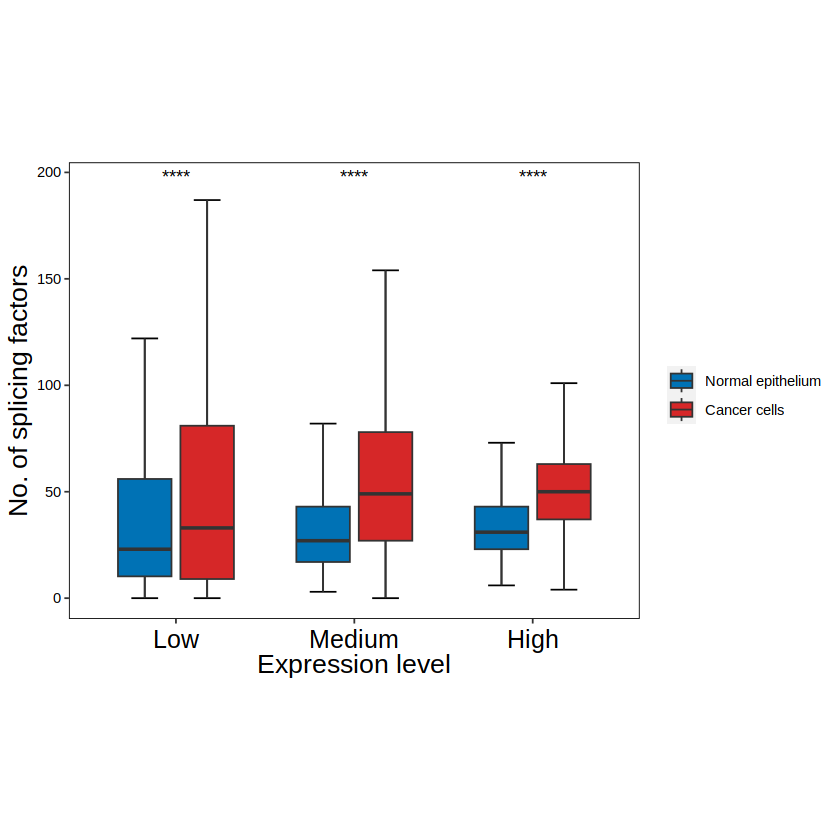

In [328]:
ont <- readRDS(file = "00_tx_5400_3262_hvg1869_PC1_20.rds")
df_sf <- as.data.frame(ont@assays$GENE@data[sf, ])
df_sf <- data.frame(
  # `None` = colSums(df_sf == 0),
  `Low` = colSums(df_sf > 0 & df_sf <= log(onethird / 10 + 1)),
  `Medium` = colSums(df_sf > log(onethird / 10 + 1) & df_sf <= log(twothirds / 10 + 1)),
  `High` = colSums(df_sf > log(twothirds / 10 + 1)), check.names = F
)
all(rownames(df_sf) == ont$CellName)
df_sf$celltype1 <- ont$celltype1

df_sf_melt <- melt(df_sf, id.vars = c("celltype1"))
ggplot(data = df_sf_melt, aes(x = variable, y = value, fill = celltype1)) +
  stat_boxplot(geom = "errorbar", linetype = 1, color = "black", position = position_dodge(width = 0.7), width = 0.3) +
  geom_boxplot(outlier.shape = NA, position = position_dodge(width = 0.7), width = 0.6) +
  stat_compare_means(method = "wilcox.test", label = "p.signif") +
  scale_fill_manual(values = celltype1_color) +
  labs(x = "Expression level", y = "No. of splicing factors") +
  mytheme +
  theme(
    aspect.ratio = 0.8, axis.text.x = element_text(size = 15, vjust = 0.5, color = "black"),
    axis.text.y = element_text(color = "black"),
    axis.title = element_text(size = 16),
    legend.title = element_blank()
  )
ggsave("Splicing_factors_expression_pvalue_2.2e10-16.pdf", width = 6, height = 3.6)

# DTE and GO

In [281]:
ont <- readRDS(file = "00_tx_5400_3262_hvg1869_PC1_20.rds")

In [283]:
DefaultAssay(ont) <- "RNA"
Idents(object = ont) <- ont@meta.data$celltype1
dte <- FindAllMarkers(ont, only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.25)

Calculating cluster Normal epithelium

Calculating cluster Cancer cells



In [284]:
dte <- dte[which(dte$p_val_adj < 0.05 & dte$avg_log2FC > log2(2)), ]
table(dte$cluster)


Normal epithelium      Cancer cells 
              440              1136 

In [285]:
dte$TranName <- rownames(dte)
info <- read.table(file = "../../CRC_HTCRC_00_gene_isoform_info/00_corrected_ref_TranID_TranName_GeneName_structural_category_expression_proportion_rank.txt", header = T, sep = "\t")
dte <- merge(dte, info[, c("TranName", "GeneName")], by = "TranName", all.x = T)

In [286]:
dte_crc <- read.table(file = "../../02_RNA_seurat/01_RNA_2184_1395_tx/7_DTE_FC2.txt", header = T, sep = "\t")
length(unique(intersect(dte_crc$GeneName, dte$GeneName)))
# dim(dte_crc)

[1] 794

In [287]:
write.table(dte, file = "7_DTE_FC2.txt", sep = "\t", quote = F)

In [288]:
# keytypes(org.Hs.eg.db)
df_gene <- bitr(dte$GeneName, fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL"), OrgDb = org.Hs.eg.db)
colnames(df_gene) <- c("GeneName", "ENTREZID", "ENSEMBL")
df_gene <- merge(dte, df_gene, by = "GeneName", all.y = T)
head(df_gene, 1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(dte$GeneName, fromType = "SYMBOL", toType = c("ENTREZID", :
“0.23% of input gene IDs are fail to map...”


GeneName TranName p_val        avg_log2FC pct.1 pct.2 p_val_adj   
1 AAR2     AAR2-201 9.806829e-21 1.18593    0.163 0.035 2.886052e-16
  cluster      gene     ENTREZID ENSEMBL        
1 Cancer cells AAR2-201 25980    ENSG00000131043

In [289]:
formula_go <- compareCluster(
  ENTREZID ~ cluster, #+ DEG,
  fun = "enrichGO", data = df_gene,
  pvalueCutoff = 0.05, pAdjustMethod = "BH", qvalueCutoff = 0.05,
  OrgDb = "org.Hs.eg.db", ont = "BP"
)

In [290]:
df_results <- formula_go@compareClusterResult
df_results <- df_results[order(df_results$Cluster, df_results$p.adjust), ]
df_results$generatio <- sapply(df_results$GeneRatio, function(x) {
  eval(parse(text = x))
})

In [292]:
table(df_results$Cluster)


Normal epithelium      Cancer cells 
               57               387 

In [293]:
write.table(df_results, file = "7_DTE_GO.txt", sep = "\t", quote = F)

In [294]:
df_results_crc <- read.table(file = "../../02_RNA_seurat/01_RNA_2184_1395_tx/7_DTE_GO.txt", header = T, sep = "\t")

In [295]:
suppressMessages({
  options(stringsAsFactors = FALSE)
  library(DESeq2)
  library(clusterProfiler)
  library(enrichplot)
  library(tidyverse)
  library(org.Hs.eg.db)
  library(DOSE)
  library(pathview)
  library(msigdbr)
  library(dplyr)
  library(ggplot2)
  library(pheatmap)
  library(RColorBrewer)
  library(ggrepel)
  library(tidyverse)
})

In [296]:
dte$group <- "Down"
dte[which(dte$cluster %in% "Cancer cells"), ]$group <- "Up"

In [ ]:
deg_up <- dte[which(dte$group %in% "Up"), ]
deg_down <- dte[which(dte$group %in% "Down"), ]
gene_up_entrez <- as.character(na.omit(bitr(
  deg_up$GeneName,
  fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL"), OrgDb = "org.Hs.eg.db"
)[, 2]))
gene_down_entrez <- as.character(na.omit(bitr(
  deg_down$GeneName,
  fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL"), OrgDb = "org.Hs.eg.db"
)[, 2]))
gene_diff_entrez <- unique(c(gene_up_entrez, gene_down_entrez))

for (regulated in c("Up", "Down")) {
  if (regulated == "Up") {
    gene_entrez <- gene_up_entrez
    deg_regulated <- deg_up
  } else {
    gene_entrez <- gene_down_entrez
    deg_regulated <- deg_down
  }
  # genelist with log2FC
  genelist <- as.numeric(deg_regulated$avg_log2FC)
  names(genelist) <- deg_regulated$SYMBOL

  print("GO analysis...")
  go <- enrichGO(gene = gene_entrez, OrgDb = "org.Hs.eg.db", ont = "BP", pvalueCutoff = 0.05, qvalueCutoff = 0.2, readable = TRUE)
  saveRDS(go, file = sprintf("7_GOenrich_FC2_%s.rds", regulated))
  write.table(as.data.frame(go), file = sprintf("7_GOenrich_FC2_%s.txt", regulated), quote = F, sep = "\t", row.names = F)

  n <- ifelse(dim(go)[1] > 25, 25, dim(go)[1])
  print("GO Plotting...")
  goplot(go, showCategory = n) # a directed acyclic graph
  ggsave(sprintf("7_GOenrich_goplot_FC2_%s.pdf", regulated), width = 10, height = 10)

  enrichplot::dotplot(go, font.size = 14, showCategory = n) +
    theme(legend.key.size = unit(10, "pt"), plot.margin = unit(c(1, 1, 1, 1), "lines"))
  ggsave(sprintf("7_GOenrich_dotplot_FC2_%s.pdf", regulated), width = 10, height = 10)

  treeplot(pairwise_termsim(go), showCategory = n)
  ggsave(sprintf("7_GOenrich_treeplot_FC2_%s.pdf", regulated), width = 20, height = 10)

  cnetplot(go, foldChange = genelist, showCategory = n, colorEdge = T, node_label = "all", color_category = "steelblue")
  ggsave(sprintf("7_GOenrich_cnetplot1_FC2_%s.pdf", regulated), width = 10, height = 10)

  cnetplot(go, foldChange = genelist, showCategory = n, node_label = "gene", circular = T, colorEdge = T)
  ggsave(sprintf("7_GOenrich_cnetplot2_FC2_%s.pdf", regulated), width = 10, height = 10)

  ### emapplot :Enrichment Map
  emapplot(pairwise_termsim(go), showCategory = n, node_label = "category")
  ggsave(sprintf("7_GOenrich_emapplot_FC2_%s.pdf", regulated), width = 10, height = 10)

  heatplot(go, foldChange = genelist, showCategory = n)
}

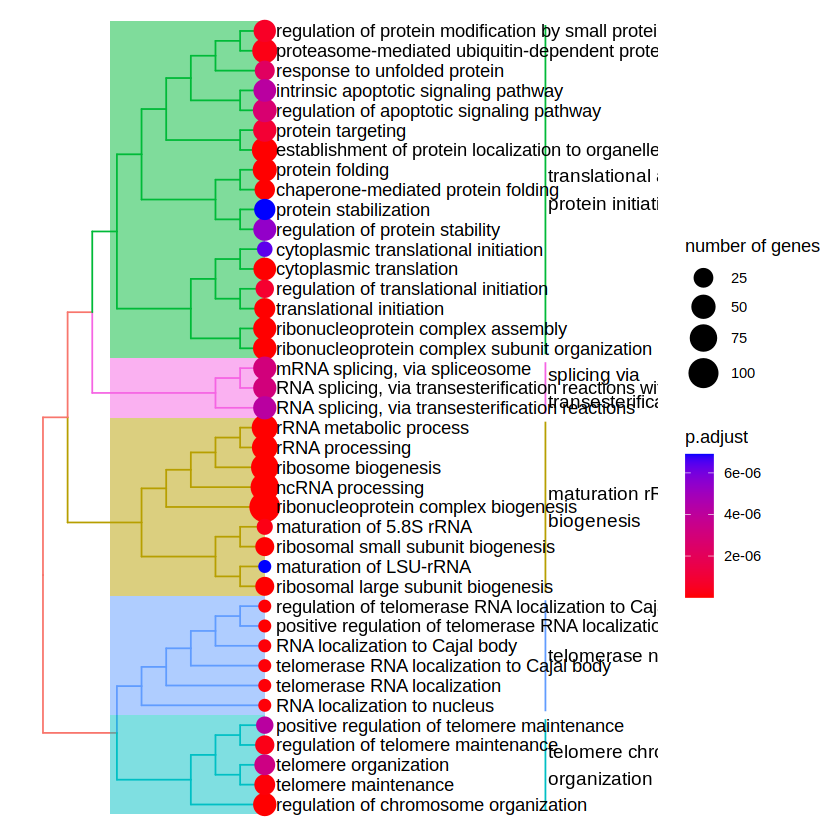

In [322]:
go <- readRDS(file = "7_DTE_GO_CRC/7_GOenrich_FC2_Up.rds")
go_filtered <- go
go_filtered@result <- subset(go_filtered@result, Count > 10)
treeplot(pairwise_termsim(go_filtered), showCategory = 40)
ggsave(sprintf("7_GOenrich_treeplot_FC2_Up_count10_show40.pdf"), width = 16, height = 10)

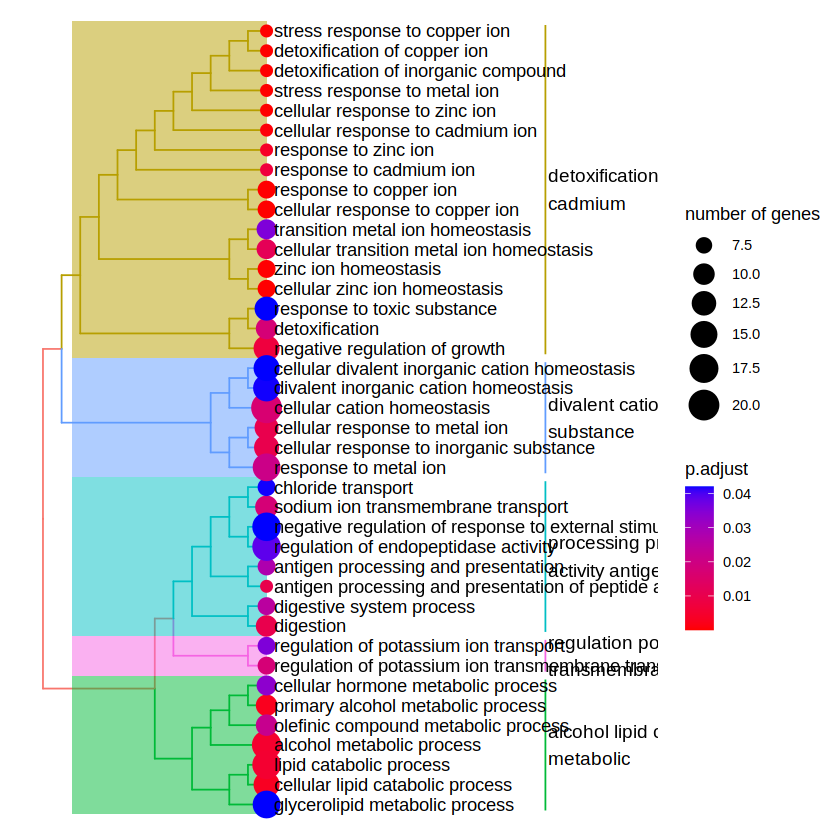

In [328]:
# go <- readRDS(file='7_GOenrich_FC2_Down.rds')
# treeplot(pairwise_termsim(go), showCategory = 25)
# ggsave(sprintf("7_GOenrich_treeplot_FC2_Down.pdf"), width = 16, height = 7)

go <- readRDS(file = "7_GOenrich_FC2_Down.rds")
go_filtered <- go
go_filtered@result <- subset(go_filtered@result, Count > 5)
treeplot(pairwise_termsim(go_filtered), showCategory = 40)
ggsave(sprintf("7_GOenrich_treeplot_FC2_Down_count5_show40.pdf"), width = 16, height = 10)